# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

Заказчик этого исследования — сеть отелей «Как в гостях». 
Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.
Чтобы решить эту проблему, вам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.
Бизнес-метрика и другие данные
Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца. 
В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня. 
Стоимость номеров отеля:

    категория A: за ночь — 1 000, разовое обслуживание — 400;
    категория B: за ночь — 800, разовое обслуживание — 350;
    категория C: за ночь — 600, разовое обслуживание — 350;
    категория D: за ночь — 550, разовое обслуживание — 150;
    категория E: за ночь — 500, разовое обслуживание — 150;
    категория F: за ночь — 450, разовое обслуживание — 150;
    категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.
Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.
На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

Нужно посчитать изменения в доходах сети отелей после внедрения системы депозитов для страховки отказов.



In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score 
from sklearn.metrics import  roc_auc_score

from sklearn.preprocessing import OrdinalEncoder
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance

RANDOM_STATE = 123
warnings.filterwarnings('ignore')

### Шаг 1. Откройте файлы с данными

In [2]:
pd.set_option('display.max_columns', 100)

У нас есть два датасета - один для обучения модели, другой для прогноза.

In [3]:
df = pd.read_csv('/datasets/hotel_train.csv')  
df_test = pd.read_csv('/datasets/hotel_test.csv') 

### Описание данных

В таблицах hotel_train и hotel_test содержатся одинаковые столбцы:

    id — номер записи;
    adults  — количество взрослых постояльцев;
    arrival_date_year — год заезда;
    arrival_date_month — месяц заезда;
    arrival_date_week_number — неделя заезда;
    arrival_date_day_of_month — день заезда;
    babies — количество младенцев;
    booking_changes — количество изменений параметров заказа;
    children — количество детей от 3 до 14 лет;
    country — гражданство постояльца;
    customer_type  — тип заказчика:
      
        Contract — договор с юридическим лицом;
        Group — групповой заезд;
        Transient — не связано с договором или групповым заездом;
        Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
    days_in_waiting_list — сколько дней заказ ожидал подтверждения;
    distribution_channel — канал дистрибуции заказа;
    is_canceled — отмена заказа;
    is_repeated_guest — признак того, что гость бронирует номер второй раз;
    lead_time — количество дней между датой бронирования и датой прибытия;
    meal — опции заказа:
      
        SC — нет дополнительных опций;
        BB — включён завтрак;
        HB — включён завтрак и обед;
        FB — включён завтрак, обед и ужин.
    previous_bookings_not_canceled — количество подтверждённых заказов у клиента;
    previous_cancellations — количество отменённых заказов у клиента;
    required_car_parking_spaces — необходимость места для автомобиля;
    reserved_room_type  — тип забронированной комнаты;
    stays_in_weekend_nights — количество ночей в выходные дни;
    stays_in_week_nights — количество ночей в будние дни;
    total_nights — общее количество ночей;
    total_of_special_requests — количество специальных отметок.

### Шаг 2. Предобработка и исследовательский анализ данных

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

Довольно много параметров, посмотрю, все ли совпадают.

In [6]:
print(df.columns==df_test.columns)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]


Хорошо. Таблицы одинаковые по параметрам. И обе полные - нет пропусков. Посмотрю дубли.

In [7]:
df.duplicated().sum()

0

In [8]:
df_test.duplicated().sum()

0

Полные дубликаты отсутствуют. Посмотрим, что же внутри таблицы.

In [9]:
df.sample(8)


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
63081,81784,0,56.0,2016,November,47,14,1,2,2.0,0.0,0.0,BB,FRA,TA/TO,0,0,0,A,0,0,Transient,0,0,3
29851,37791,1,8.0,2016,June,27,29,0,3,2.0,0.0,0.0,BB,FRA,TA/TO,0,0,0,D,0,0,Transient,0,1,3
37801,56156,1,360.0,2015,October,42,12,1,1,2.0,0.0,0.0,BB,PRT,TA/TO,0,1,0,A,0,0,Contract,0,0,2
16322,19124,0,5.0,2016,December,51,14,0,1,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
33010,40950,1,258.0,2016,September,40,29,0,1,2.0,0.0,0.0,BB,CN,TA/TO,0,0,0,A,0,0,Transient,0,1,1
28548,36488,1,118.0,2016,June,24,6,1,1,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,1,0,Transient-Party,0,0,2
22167,30107,1,98.0,2015,November,48,23,1,2,1.0,0.0,0.0,FB,PRT,TA/TO,0,0,0,A,0,0,Transient-Party,0,0,3
3786,3824,1,236.0,2016,May,20,12,1,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient-Party,0,0,4


In [10]:
df_test.sample(8)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
207,6299,1,40.0,2017,February,7,12,2,3,2.0,0.0,0.0,BB,USA,TA/TO,0,0,0,A,0,0,Transient,0,0,5
25558,91050,0,26.0,2017,May,18,5,2,3,2.0,0.0,0.0,BB,DEU,TA/TO,0,0,0,A,0,0,Transient,0,1,5
72,6160,1,1.0,2017,January,3,17,0,2,1.0,0.0,0.0,SC,PRT,Direct,0,0,0,A,1,0,Transient-Party,0,0,2
26990,92482,0,130.0,2017,May,21,26,2,2,2.0,0.0,0.0,SC,FRA,TA/TO,0,0,0,A,0,0,Transient,0,0,4
11351,48540,1,14.0,2017,April,15,14,0,2,2.0,0.0,0.0,SC,PRT,TA/TO,0,0,0,A,0,0,Transient,0,2,2
513,6606,1,26.0,2017,March,11,14,0,5,2.0,0.0,0.0,HB,PRT,Direct,0,0,0,E,0,0,Transient-Party,0,0,5
2488,15087,0,1.0,2017,January,2,14,0,1,2.0,0.0,0.0,BB,PRT,TA/TO,1,0,1,A,0,0,Transient,0,1,1
3676,20601,0,3.0,2017,February,7,13,1,3,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,4


Посмотрим количество оригинальных значений в каждом категориальном признаке, чтоб принять решение о замене их на числовые значения.

In [11]:
categorial = ['arrival_date_month', 'meal', 'country', 'distribution_channel', 'reserved_room_type', 'customer_type']

for itm in categorial:
    print(itm, ':', df[itm].nunique(), 'оригинальных значений')

arrival_date_month : 12 оригинальных значений
meal : 5 оригинальных значений
country : 155 оригинальных значений
distribution_channel : 4 оригинальных значений
reserved_room_type : 7 оригинальных значений
customer_type : 4 оригинальных значений


In [12]:
for itm in categorial:
    print(itm, ':', df_test[itm].nunique(), 'оригинальных значений')

arrival_date_month : 8 оригинальных значений
meal : 5 оригинальных значений
country : 143 оригинальных значений
distribution_channel : 4 оригинальных значений
reserved_room_type : 7 оригинальных значений
customer_type : 4 оригинальных значений


In [13]:
columns = df.columns

In [14]:
for itm in  columns:
    print(itm, 'оригинальные значения:', df[itm].unique())

id оригинальные значения: [    0     1     2 ... 84094 84117 84121]
is_canceled оригинальные значения: [0 1]
lead_time оригинальные значения: [  7.  14.   0.   9.  85.  75.  23.  18.  68.  37.  72.  48.  77.  99.
  40.  15.  36.  70.  45.  16. 107.  47.  96. 113.  50.   3.   1.  10.
   5.  17.  93.  71.  63.  62. 101.   2.  81.  12. 109. 102.   4.  92.
  95.  86.  78.  29.  30.  51.  33.   8. 100.  80.  97.  64.  90.  27.
  82.  94. 115. 111.  98.  66. 104.  65.  55.  21.  88.  43.  54. 280.
  24. 103. 249.  13.  79.  35.  31.  34.  44. 304. 117.  84. 110.  59.
 116.  91.  42.  60. 321.  32.  56.  41.  76.  49.  73. 112.  39.  58.
  57.  19.  53.  38.   6. 108.  26. 123.  28. 118.  46.  69.  52.  89.
  61.  22.  67. 105.  25.  11.  87. 299.  74. 298. 119.  20.  83. 136.
 129. 124. 130. 131. 139. 122. 106. 137. 120. 135. 150. 143. 151. 126.
 147. 128. 156. 132. 164. 159. 161. 333. 149. 154. 297. 163. 314. 323.
 340. 142. 302. 175. 166. 114. 140. 157. 310. 172. 145. 121. 127. 178.
 152. 

    Нужно откорректировать некоторые моменты:

    lead_time - перевести тип данных в целые, нет дробных значений
    аdults - перевести тип данных в целые, нет дробных значений 
    children - перевести тип данных в целые, нет дробных значений 
    babies - перевести тип данных в целые, нет дробных значений
    meal - пробелы
    reserved_room_type - пробелы

In [15]:
for itm in  columns:
    print(itm, 'оригинальные значения:', df_test[itm].unique())

id оригинальные значения: [ 6086  6087  6088 ... 97901 97902 97903]
is_canceled оригинальные значения: [1 0]
lead_time оригинальные значения: [ 74.  62.  71. 172.  52. 143.  21.  89.  48.  31.  20. 173.  23.  46.
 149.  44.  68.   6.  43. 112.  59.  93.   4. 115. 187.  11.   2.  15.
  66. 113. 125. 161. 154.   1.   0.  35.  37.  60. 129.  78.  10.  82.
   8.  22.  33. 108.  87. 106.  45.  40.  17.   5.  16.   3.  41. 135.
 123. 128.  47.  12. 124. 160.  58.  65. 281.  24.  30.  27.   9.  94.
 219.  84.  79.  72.  36. 292. 186.  85. 169. 166.  28.  83. 111.  54.
 200.  80. 102.  95. 170. 307. 298.  55.  77.  32.  25. 238.   7.  19.
 211. 137.  39.  18. 206.  42. 179. 205. 142.  38.  92.  56.  29. 119.
  73. 320.  34. 127.  69.  13. 140.  14. 164.  51.  70. 120.  76. 105.
  50. 191.  26.  75. 116. 184.  53.  49.  63. 194. 167. 312. 171. 218.
  86. 100. 146.  64. 148.  81.  88.  57. 339. 332. 133. 208.  61. 177.
 157. 278. 285. 210. 232. 139. 134. 204. 201. 216. 340. 350. 214. 226.
 273. 

Такие же нюансы.


In [16]:
df['lead_time'] = df['lead_time'].astype('int')
df['adults'] = df['adults'].astype('int')
df['children'] = df['children'].astype('int')
df['babies'] = df['babies'].astype('int')
df['meal'] = df['meal'].str.strip()
df['reserved_room_type'] = df['reserved_room_type'].str.strip()

df_test['lead_time'] = df_test['lead_time'].astype('int')
df_test['adults'] = df_test['adults'].astype('int')
df_test['children'] = df_test['children'].astype('int')
df_test['babies'] = df_test['babies'].astype('int')
df_test['meal'] = df['meal'].str.strip()
df_test['reserved_room_type'] = df['reserved_room_type'].str.strip()


Теперь посмотрим на изменения в таблицах.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id                              65229 non-null  int64 
 1   is_canceled                     65229 non-null  int64 
 2   lead_time                       65229 non-null  int64 
 3   arrival_date_year               65229 non-null  int64 
 4   arrival_date_month              65229 non-null  object
 5   arrival_date_week_number        65229 non-null  int64 
 6   arrival_date_day_of_month       65229 non-null  int64 
 7   stays_in_weekend_nights         65229 non-null  int64 
 8   stays_in_week_nights            65229 non-null  int64 
 9   adults                          65229 non-null  int64 
 10  children                        65229 non-null  int64 
 11  babies                          65229 non-null  int64 
 12  meal                            65229 non-null

In [18]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id                              32412 non-null  int64 
 1   is_canceled                     32412 non-null  int64 
 2   lead_time                       32412 non-null  int64 
 3   arrival_date_year               32412 non-null  int64 
 4   arrival_date_month              32412 non-null  object
 5   arrival_date_week_number        32412 non-null  int64 
 6   arrival_date_day_of_month       32412 non-null  int64 
 7   stays_in_weekend_nights         32412 non-null  int64 
 8   stays_in_week_nights            32412 non-null  int64 
 9   adults                          32412 non-null  int64 
 10  children                        32412 non-null  int64 
 11  babies                          32412 non-null  int64 
 12  meal                            32412 non-null

In [19]:
column = ['lead_time', 'adults', 'children', 'babies', 'meal', 'reserved_room_type', 'country', 'distribution_channel', 'customer_type', 'arrival_date_month']

for itm in  column:
    print('df', itm, 'оригинальные значения:', df[itm].unique())
    print('\ndf_test', itm, 'оригинальные значения:', df_test[itm].unique())
    print('\n-------------------------------------\n')

df lead_time оригинальные значения: [  7  14   0   9  85  75  23  18  68  37  72  48  77  99  40  15  36  70
  45  16 107  47  96 113  50   3   1  10   5  17  93  71  63  62 101   2
  81  12 109 102   4  92  95  86  78  29  30  51  33   8 100  80  97  64
  90  27  82  94 115 111  98  66 104  65  55  21  88  43  54 280  24 103
 249  13  79  35  31  34  44 304 117  84 110  59 116  91  42  60 321  32
  56  41  76  49  73 112  39  58  57  19  53  38   6 108  26 123  28 118
  46  69  52  89  61  22  67 105  25  11  87 299  74 298 119  20  83 136
 129 124 130 131 139 122 106 137 120 135 150 143 151 126 147 128 156 132
 164 159 161 333 149 154 297 163 314 323 340 142 302 175 166 114 140 157
 310 172 145 121 127 178 152 158 125 185 177 165 200 192 174 134 350 283
 160 133 148 153 155 171 146 241 193 235 194 209 238 215 141 189 223 169
 202 211 168 230 203 188 232 187 219 196 190 228 176 197 201 186 199 180
 207 138 162 224 144 222 275 212 214 183 218 206 208 191 181 229 179 173
 253 260 262 23

Из всех значений подозрительными выглядят 9 и 10 детей. И надо обратить внимание на восемь месяцев из 12 в тестовом сете, потому что прибыль будем считать за год.

#### Матрица корреляции


Столбец 'id' не влияет на рассматриваемую ситуацию, поэтому удалю его из датасета.

In [20]:
df_test = df_test.drop('id', axis=1)
df = df.drop('id', axis=1)

А теперь посмотрю на дубли.

In [21]:
df.duplicated().sum()

21377

In [22]:
df_test.duplicated().sum()

5607

Удаляю дубликаты и посмотрю матрицу корреляции df.

<AxesSubplot:>

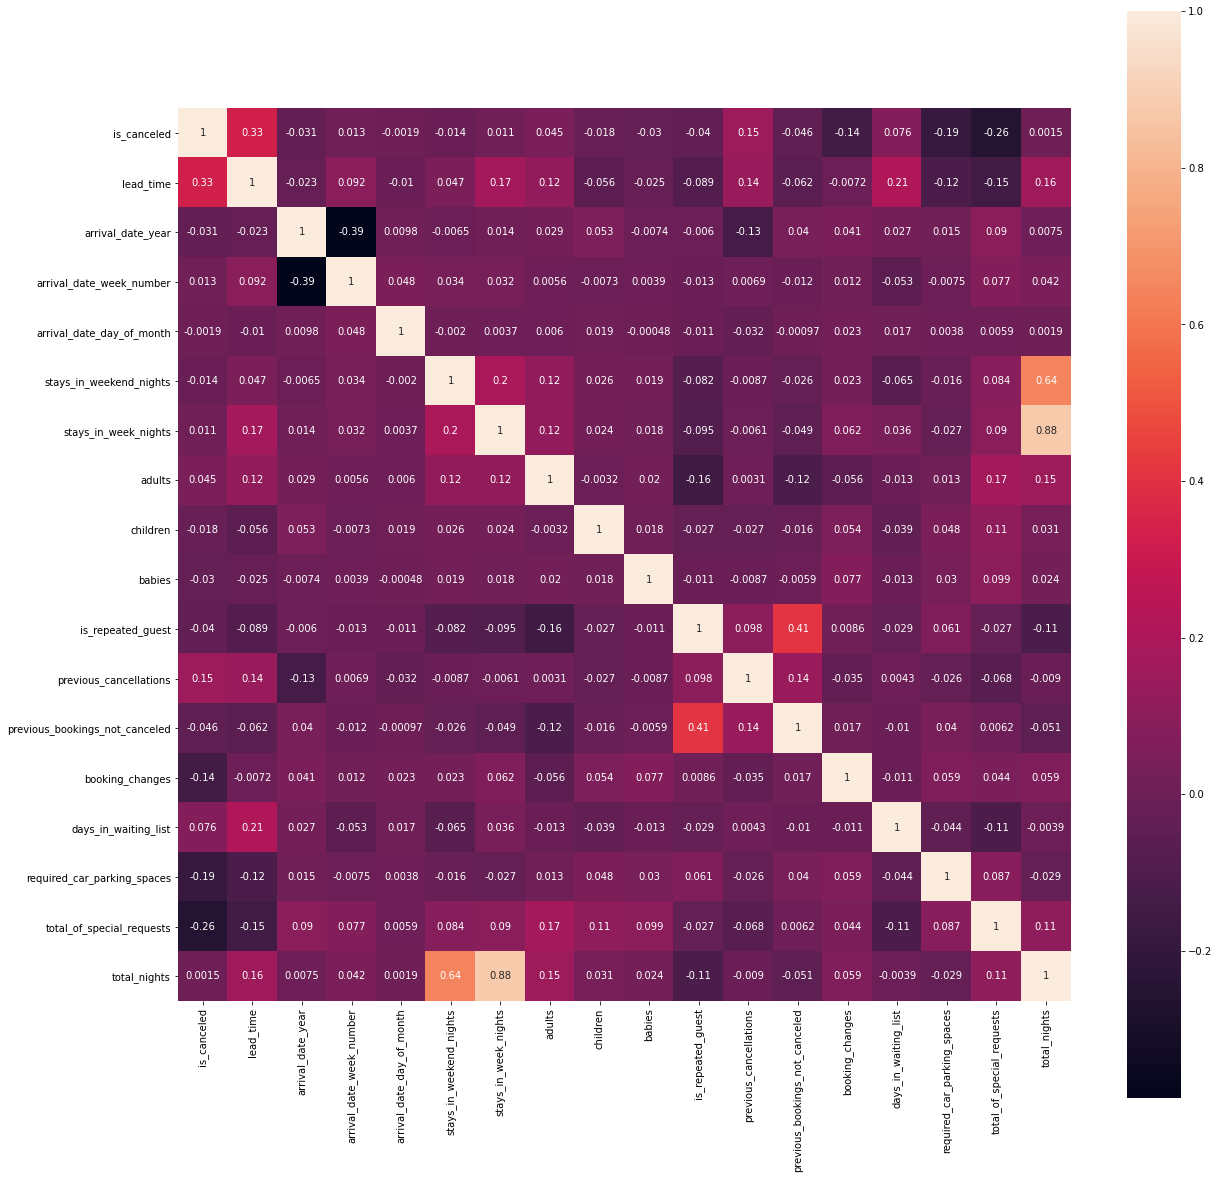

In [23]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), annot=True, square=True)

Видим, что параметры 'stays_in_weekend_nights', 'stays_in_week_nights', 'total_nights' связаны, и матрица корреляции показывает эту связь.

Также возможна связь между параметрами 'previous_booking_not_canceled' и 'is_repeated_guest'. 

Исследую эти связи далее.

#### Обработка параметров


In [24]:
df.groupby('babies')['is_canceled'].count()


babies
0     64777
1       447
2         3
9         1
10        1
Name: is_canceled, dtype: int64

In [25]:
df_test.groupby('babies')['is_canceled'].count()

babies
0    32237
1      171
2        4
Name: is_canceled, dtype: int64

Уберем 9 и 10 как аномальные значения, а 2 как незначительные по количеству.

In [26]:
a = [0, 1]
df = df[df['babies'].isin(a)]
df_test = df_test[df_test['babies'].isin(a)]

Предлагаю посмотреть на сумму ночей в выходные и будни и сравнить их с общим число ночей.

In [27]:
is_sum = df['total_nights'] == df['stays_in_weekend_nights'] + df['stays_in_week_nights']

print(is_sum.sum() == len(df))


True


Удаляю один параметр, потому что все три признака в этом случае нам не нужны.

In [28]:
df = df.drop('stays_in_week_nights', axis=1)
df_test = df_test.drop('stays_in_week_nights', axis=1)

Ошибок не обнаружено.

Проверим, что для февраля не более 28 дней в переменной arrival_date_day_of_month, а для апреля, июня, сентября и ноября  - не более 30.

In [29]:
df[df['arrival_date_day_of_month']>28].loc[df['arrival_date_month']=='February'].groupby('arrival_date_year')['arrival_date_year'].count()

arrival_date_year
2016    83
Name: arrival_date_year, dtype: int64

2016 год был високосным. Эти 83 записи относятся к 29 февраля.

In [30]:
df.loc[df['arrival_date_day_of_month']>29].groupby('arrival_date_month')['arrival_date_day_of_month'].count()

arrival_date_month
April        168
August       395
December     507
January       78
July         361
June         153
March        342
May          335
November     102
October      540
September    443
Name: arrival_date_day_of_month, dtype: int64

In [31]:
df.loc[df['arrival_date_day_of_month']>30].groupby('arrival_date_month')['arrival_date_day_of_month'].count()

arrival_date_month
August      206
December    160
January      26
July        126
March       205
May         176
October     253
Name: arrival_date_day_of_month, dtype: int64

И тут мы наблюдаем адекватное количество дней в месяцах.

Количество парковочных мест посмотрим.

In [32]:
df.groupby('required_car_parking_spaces')['is_canceled'].count()

required_car_parking_spaces
0    61543
1     3669
2       11
3        1
Name: is_canceled, dtype: int64

In [33]:
df_test.groupby('required_car_parking_spaces')['is_canceled'].count()

required_car_parking_spaces
0    30933
1     1466
2        6
3        1
8        2
Name: is_canceled, dtype: int64

Удалим 2, 3 и 8.

In [34]:
df = df[df['required_car_parking_spaces']<2]
df_test = df_test[df_test['required_car_parking_spaces']<2]

Проанализирую взрослых и детей.

In [35]:
df.groupby('adults')['is_canceled'].count()

adults
0      166
1    13209
2    48966
3     2858
4       13
Name: is_canceled, dtype: int64

In [36]:
df.groupby('children')['is_canceled'].count()

children
0    61697
1     2163
2     1336
3       16
Name: is_canceled, dtype: int64

Взрослые без детей - нормально, но дети без взрослых - подозрительно

In [37]:
df = df.loc[df['adults']!=0]
df_test.groupby('adults')['is_canceled'].count()

adults
0       69
1     6280
2    24224
3     1817
4        9
Name: is_canceled, dtype: int64

In [38]:
df_test = df_test.loc[df_test['adults']!=0]

In [39]:
df.groupby('is_canceled')['is_canceled'].count()

is_canceled
0    41050
1    23996
Name: is_canceled, dtype: int64

Это целевой параметр. Мы видим, что отказавшихся примерно в два раза меньше, чем не отказавшихся. На лицо дисбаланс классов, на основе чего я предлагаю использовать метрику auc-roc для оценки модели, потому что она хорошо с этим дисбалансом справляется, для неё не надо балансировку проводить.

In [40]:
df.groupby('arrival_date_year')['is_canceled'].count()

arrival_date_year
2015    18311
2016    46735
Name: is_canceled, dtype: int64

In [41]:
df.groupby('arrival_date_week_number')['is_canceled'].count()

arrival_date_week_number
1      202
2      331
3      354
4      483
5      485
6      572
7      800
8      892
9      842
10     889
11     786
12     887
13    1150
14     873
15    1134
16    1058
17    1208
18    1208
19     958
20    1061
21    1205
22     940
23    1143
24    1063
25    1319
26     920
27    1250
28    1185
29    1354
30    1438
31    1161
32    1438
33    1743
34    1427
35    1406
36    1730
37    1864
38    2316
39    2162
40    1984
41    2236
42    2357
43    1878
44    1814
45    1638
46    1321
47    1416
48    1296
49    1447
50    1251
51     750
52     923
53    1498
Name: is_canceled, dtype: int64

Недель 53, не больше, в году. Комментировать нечего.

<AxesSubplot:xlabel='arrival_date_week_number'>

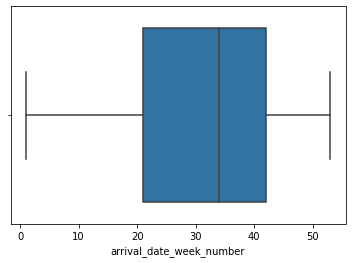

In [42]:
sns.boxplot(x=df['arrival_date_week_number'])

Большая часть посещений - тёплый сезон.

In [43]:
df_test.groupby('arrival_date_week_number')['is_canceled'].count()

arrival_date_week_number
1      699
2      717
3      728
4      778
5      681
6      657
7      989
8     1051
9      949
10     960
11    1000
12     920
13     922
14    1097
15    1213
16    1022
17    1294
18    1271
19    1079
20    1260
21    1163
22    1161
23    1096
24    1025
25     990
26    1020
27     854
28     948
29     710
30     779
31     731
32     642
33     788
34     625
35     511
Name: is_canceled, dtype: int64

Промежуток с января по август включительно составляет 35 недель, учитывая неполные в начале и конце периода. Тут тоже всё нормально.

In [44]:
df.groupby('meal')['is_canceled'].count().sort_values()

meal
FB      451
SC     5777
HB     7286
BB    51532
Name: is_canceled, dtype: int64

In [45]:
df_test.groupby('meal')['is_canceled'].count().sort_values()

meal
FB      449
SC     1946
HB     4737
BB    25198
Name: is_canceled, dtype: int64

В основном заказывают завтрак.

In [46]:
df.groupby('country')['is_canceled'].count().sort_values(ascending=False)

country
PRT    28786
FRA     5958
GBR     5092
ESP     4885
DEU     3878
       ...  
NIC        1
PLW        1
PRY        1
PYF        1
ZWE        1
Name: is_canceled, Length: 155, dtype: int64

In [47]:
df_test.groupby('country')['is_canceled'].count().sort_values(ascending=False)

country
PRT    9875
GBR    3921
FRA    3468
DEU    2374
ESP    1929
       ... 
SLV       1
STP       1
IMN       1
NCL       1
ABW       1
Name: is_canceled, Length: 143, dtype: int64

Лидеры те же.

In [48]:
df.groupby('distribution_channel')['is_canceled'].count().sort_values()

distribution_channel
GDS             99
Corporate     3821
Direct        6827
TA/TO        54299
Name: is_canceled, dtype: int64

In [49]:
df_test.groupby('distribution_channel')['is_canceled'].count().sort_values()

distribution_channel
GDS             85
Corporate     1598
Direct        3632
TA/TO        27015
Name: is_canceled, dtype: int64

Здесь тоже лидирует одна группа - TA/TO.

In [50]:
df.groupby('is_repeated_guest')['is_canceled'].count()

is_repeated_guest
0    63276
1     1770
Name: is_canceled, dtype: int64

In [51]:
df_test.groupby('is_repeated_guest')['is_canceled'].count()

is_repeated_guest
0    31319
1     1011
Name: is_canceled, dtype: int64

В основном люди приезжают первый раз.

In [52]:
print('df:', round(df[df['is_repeated_guest']==1]['is_canceled'].count()/df[df['is_repeated_guest']==0]['is_canceled'].count(),\
                   2), '% людей возвращаются на отдых.')
print('df_test:', round(df_test[df_test['is_repeated_guest']==1]['is_canceled'].count()/df_test[df_test['is_repeated_guest']\
            ==0]['is_canceled'].count(), 2), '% людей возвращаются на отдых.')

df: 0.03 % людей возвращаются на отдых.
df_test: 0.03 % людей возвращаются на отдых.


In [53]:
df.groupby('previous_bookings_not_canceled')['is_canceled'].count().sort_values(ascending=False)

previous_bookings_not_canceled
0     63504
1       644
2       252
3       136
4       114
5        89
6        56
7        34
8        25
9        23
10       21
11       16
12       14
25       10
13        9
21        8
14        8
22        7
15        7
16        6
17        5
18        5
19        5
20        5
24        3
27        3
48        2
44        2
29        2
28        2
23        2
26        1
57        1
56        1
55        1
54        1
53        1
52        1
51        1
50        1
49        1
47        1
45        1
43        1
30        1
42        1
41        1
40        1
39        1
38        1
37        1
36        1
35        1
34        1
33        1
32        1
31        1
58        1
Name: is_canceled, dtype: int64

<AxesSubplot:xlabel='previous_bookings_not_canceled'>

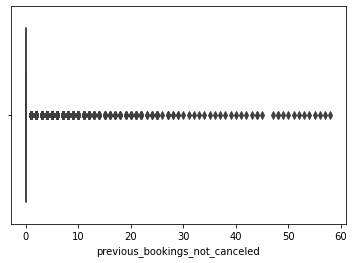

In [54]:
sns.boxplot(x=df['previous_bookings_not_canceled'])

Здесь тоже всё разнообразие значений отображается, как выбросы.

In [55]:
df.loc[df['is_repeated_guest']==1, 'previous_bookings_not_canceled'].unique()


array([ 0,  2,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 18, 21,
       22, 15, 16, 17, 19, 20, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 25])

Ноль в значении столбца 'previous_bookings_not_canceled' в этом случае неправильное значение. Удаляю эти строки.

In [56]:
df_index = df.loc[((df['is_repeated_guest']==1) & (df['previous_bookings_not_canceled']==0))].index
df = df.drop(index=df_index)

In [57]:
df_test.loc[df_test['is_repeated_guest']==1, 'previous_bookings_not_canceled'].unique()

array([ 4, 10, 11, 12, 13,  5,  2,  3,  1,  8,  9,  7,  6,  0, 23, 24, 26,
       14, 16, 15, 17, 18, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 19, 25, 27, 28, 29, 30, 20, 21, 22])

В тестовом сете нет таких проблем.

In [58]:
df.loc[df['is_repeated_guest']==0, 'previous_bookings_not_canceled'].unique()

array([ 0,  1,  2,  3,  4,  5,  6, 10, 12, 13, 15, 21,  7,  9,  8, 25, 11,
       16, 17, 19, 20, 22, 24, 27, 29])

Здесь обратная ситуация. Если человек ни разу не отдыхал в отеле, то не должно быть предыдущих неотменённых броней.

In [59]:
df_index = df.loc[(df['is_repeated_guest']==0) & (df['previous_bookings_not_canceled']!=0)].index
df = df.drop(index=df_index)

In [60]:
df_test.loc[df_test['is_repeated_guest']==0, 'previous_bookings_not_canceled'].unique()

array([ 0,  3,  2,  5,  6,  7,  8, 10, 11, 12,  4,  1,  9, 25, 27, 28, 30,
       13, 14])

In [61]:
df_index_test = df_test.loc[(df_test['is_repeated_guest']==0) & (df_test['previous_bookings_not_canceled']!=0)].index
df_test = df_test.drop(index=df_index_test)


Теперь, когда убрали неполадки, можно удалить столбец 'previous_bookings_not_canceled'. Если сделать замену в 'previous_bookings_not_canceled' всего разнообразия значений на ноль и один (нет не отменённых визитов и есть не отменённые визиты), это будет повтор столбца 'is_repeated_guest'.

In [62]:
df = df.drop('previous_bookings_not_canceled', axis=1)
df_test = df_test.drop('previous_bookings_not_canceled', axis=1)

In [63]:
df.groupby('previous_cancellations')['is_canceled'].count().sort_values(ascending=False)

previous_cancellations
0     59013
1      5003
3        47
2        44
24       28
11       22
25       19
26       18
19       17
5        13
13       11
14       11
6         7
4         5
Name: is_canceled, dtype: int64

<AxesSubplot:xlabel='previous_cancellations'>

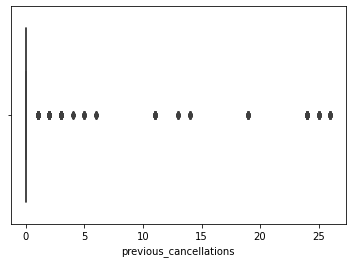

In [64]:
sns.boxplot(x=df['previous_cancellations'])

In [65]:
df_binary = df.copy()
df_binary_test = df_test.copy()

In [66]:
df.groupby('reserved_room_type')['is_canceled'].count().sort_values(ascending=False)

reserved_room_type
A    49806
D     9331
E     2402
F     1203
B      712
G      585
C      219
Name: is_canceled, dtype: int64

In [67]:
df.groupby('booking_changes')['is_canceled'].count()

booking_changes
0     55403
1      6485
2      1725
3       397
4       147
5        41
6        19
7        17
8         7
9         5
10        2
13        4
14        2
15        2
16        1
17        1
Name: is_canceled, dtype: int64

<AxesSubplot:xlabel='booking_changes'>

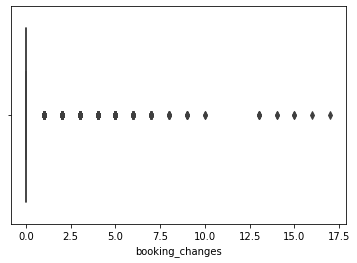

In [68]:
sns.boxplot(x=df['booking_changes'])

Делаю бинарным.

In [69]:
df.loc[df['booking_changes']!=0,'booking_changes']=1

In [70]:
df_test.loc[df_test['booking_changes']!=0,'booking_changes']=1

In [71]:
df.groupby('booking_changes')['is_canceled'].count().sort_values(ascending=False)

booking_changes
0    55403
1     8855
Name: is_canceled, dtype: int64

In [72]:
df_test.groupby('booking_changes')['is_canceled'].count().sort_values(ascending=False)

booking_changes
0    27604
1     4603
Name: is_canceled, dtype: int64

In [73]:
df.groupby('days_in_waiting_list')['is_canceled'].count()

days_in_waiting_list
0      61059
1          3
2          2
3         59
4         20
       ...  
207       15
215       21
224       10
236       35
259       10
Name: is_canceled, Length: 97, dtype: int64

<AxesSubplot:xlabel='days_in_waiting_list'>

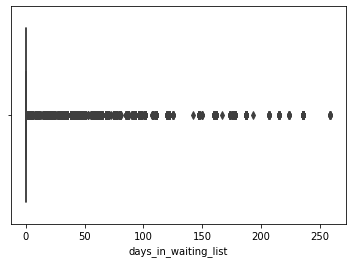

In [74]:
sns.boxplot(x=df['days_in_waiting_list'])

In [75]:
df.groupby('customer_type')['is_canceled'].count().sort_values(ascending=False)

customer_type
Transient          44995
Transient-Party    16273
Contract            2733
Group                257
Name: is_canceled, dtype: int64

In [76]:
df.groupby('total_of_special_requests')['is_canceled'].count()

total_of_special_requests
0    39991
1    16757
2     6375
3     1021
4      102
5       12
Name: is_canceled, dtype: int64

<AxesSubplot:xlabel='total_of_special_requests'>

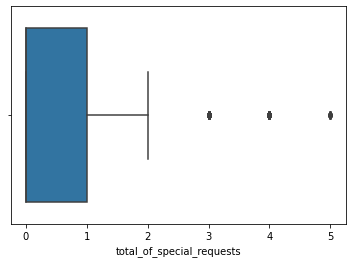

In [77]:
sns.boxplot(x=df['total_of_special_requests'])

In [78]:
df.groupby('total_nights')['is_canceled'].count()

total_nights
1     11847
2     16430
3     15475
4      9557
5      4251
6      2058
7      3837
8       540
9       146
10      117
Name: is_canceled, dtype: int64

<AxesSubplot:xlabel='total_nights'>

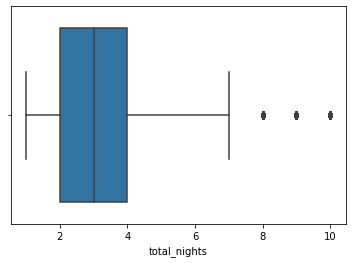

In [79]:
sns.boxplot(x=df['total_nights'])

In [80]:
df.groupby('lead_time')['is_canceled'].count().sort_values(ascending=False)

lead_time
0      3286
1      1936
2      1138
3      1040
4       973
       ... 
345       2
352       1
340       1
361       1
373       1
Name: is_canceled, Length: 368, dtype: int64

<AxesSubplot:xlabel='lead_time'>

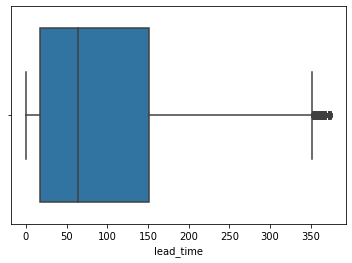

In [81]:
sns.boxplot(x=df['lead_time'])

Ориентируясь на квартили, удалим выбросы из значений параметра lead_time.

In [82]:
q1 = df['lead_time'].quantile(.25)
q3 = df['lead_time'].quantile(.75)

q0 = q1 - (q3-q1)*1.5
q4 = q3 + (q3-q1)*1.5

In [83]:
df = df.loc[(df['lead_time']>q0) & (df['lead_time']<q4)]

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63770 entries, 0 to 65228
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   is_canceled                  63770 non-null  int64 
 1   lead_time                    63770 non-null  int64 
 2   arrival_date_year            63770 non-null  int64 
 3   arrival_date_month           63770 non-null  object
 4   arrival_date_week_number     63770 non-null  int64 
 5   arrival_date_day_of_month    63770 non-null  int64 
 6   stays_in_weekend_nights      63770 non-null  int64 
 7   adults                       63770 non-null  int64 
 8   children                     63770 non-null  int64 
 9   babies                       63770 non-null  int64 
 10  meal                         63770 non-null  object
 11  country                      63770 non-null  object
 12  distribution_channel         63770 non-null  object
 13  is_repeated_guest            63

In [85]:
df.groupby('arrival_date_month')['is_canceled'].count().sort_values(ascending=False)

arrival_date_month
October      8713
September    8653
August       6573
November     5697
July         5515
December     5415
April        4756
May          4641
June         4582
March        4094
February     3287
January      1844
Name: is_canceled, dtype: int64

In [86]:
df.groupby('arrival_date_day_of_month')['is_canceled'].count()

arrival_date_day_of_month
1     1730
2     2113
3     2013
4     2069
5     2439
6     1981
7     2051
8     2114
9     2175
10    1797
11    1930
12    2195
13    1961
14    1929
15    2090
16    2187
17    2525
18    2277
19    2253
20    2182
21    2053
22    1935
23    1778
24    2223
25    2189
26    2196
27    2019
28    2126
29    1914
30    2185
31    1141
Name: is_canceled, dtype: int64

<AxesSubplot:xlabel='arrival_date_day_of_month'>

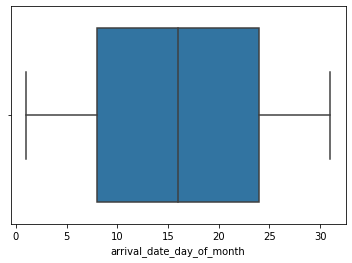

In [87]:
sns.boxplot(x=df['arrival_date_day_of_month'])

Здесь не стоило ожидать другого.

In [88]:
df.groupby('stays_in_weekend_nights')['is_canceled'].count()

stays_in_weekend_nights
0    28876
1    17347
2    17147
3      254
4      146
Name: is_canceled, dtype: int64

<AxesSubplot:xlabel='stays_in_weekend_nights'>

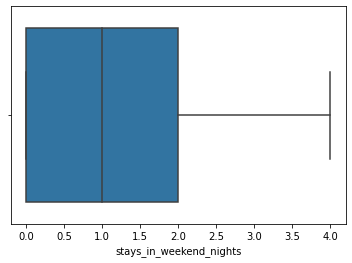

In [89]:
sns.boxplot(x=df['stays_in_weekend_nights'])

Тут тоже.

<AxesSubplot:>

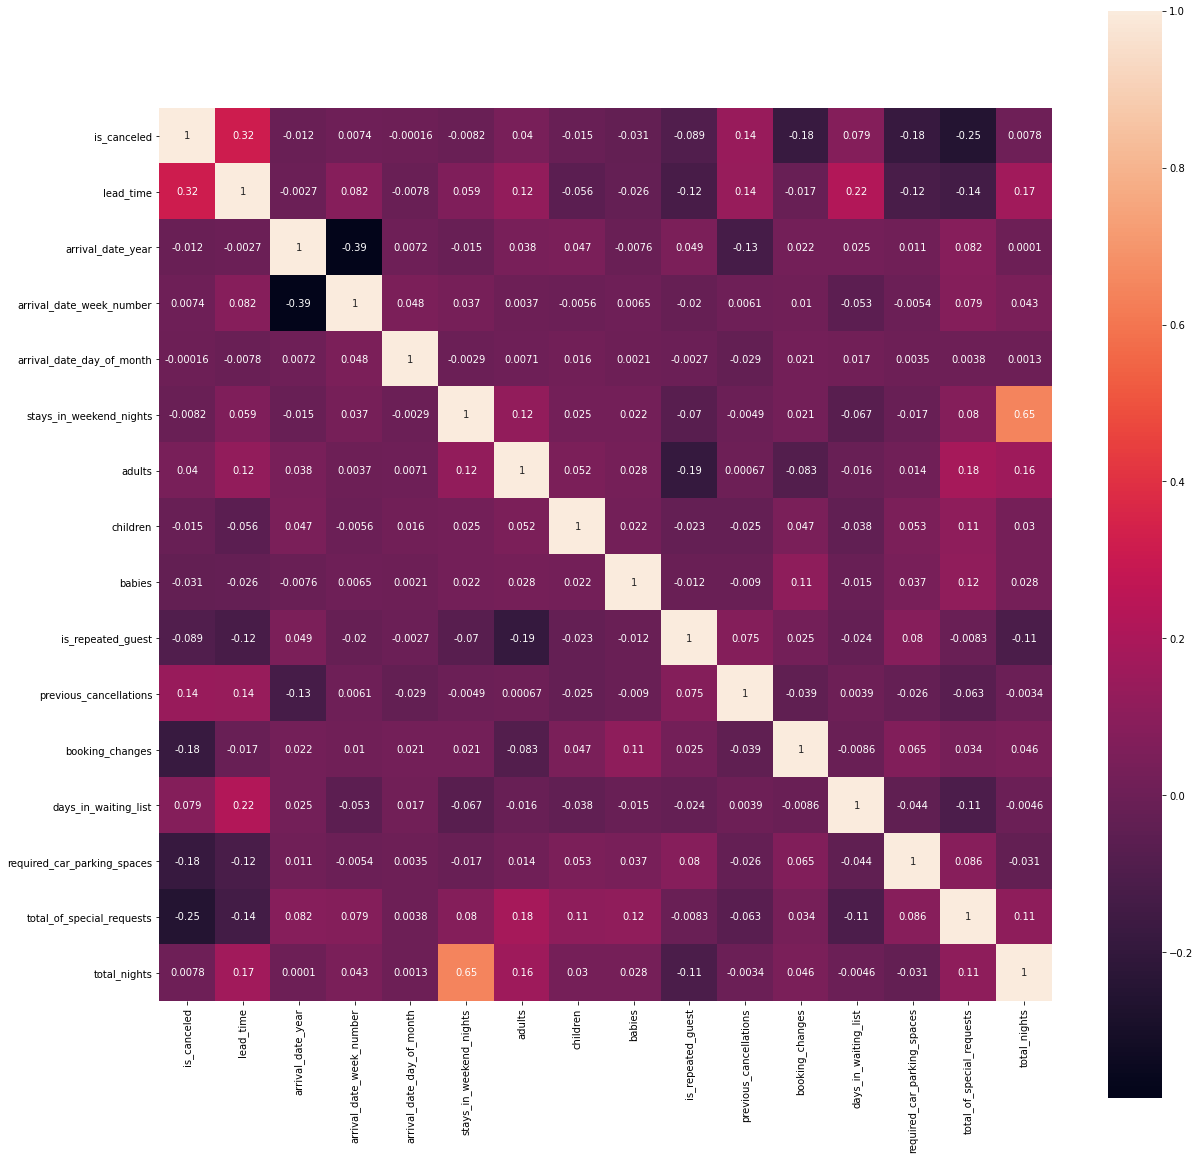

In [90]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), annot=True, square=True)

видим усиление корреляции для 'previous_cancellations'.

Визуализирую данные.

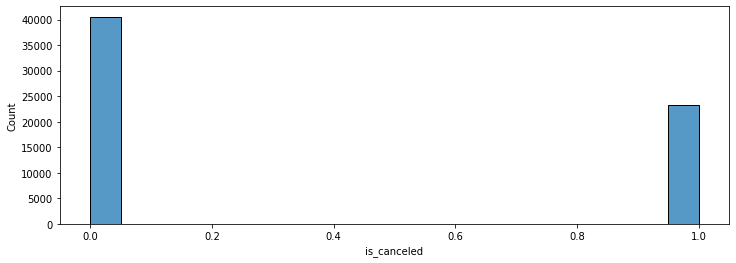

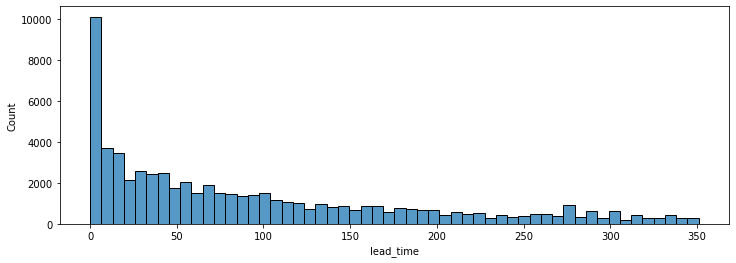

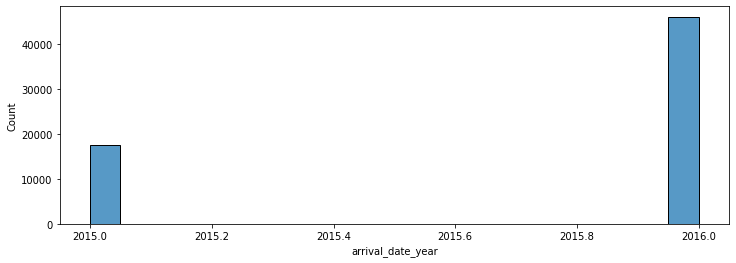

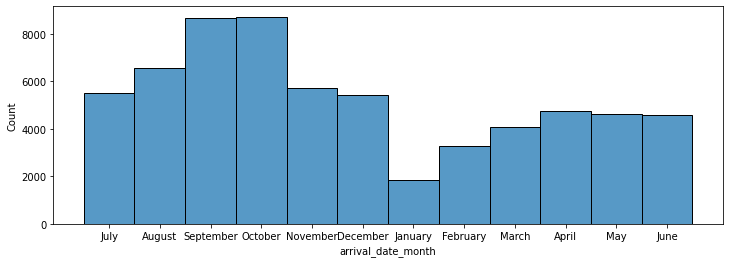

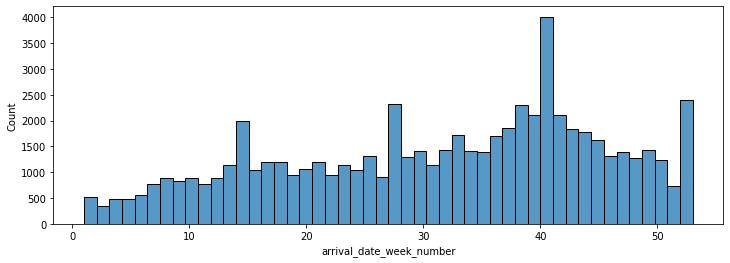

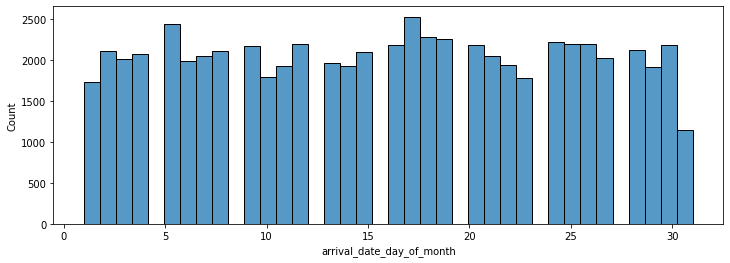

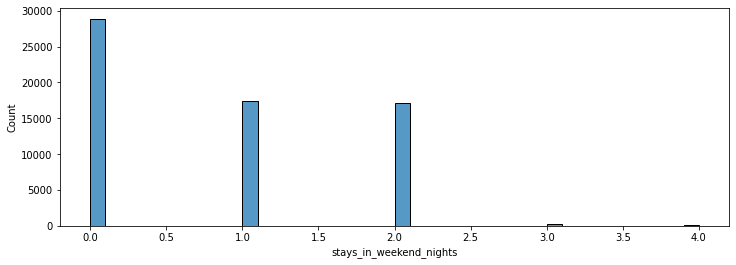

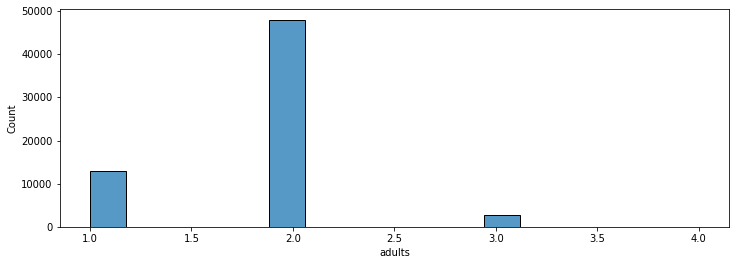

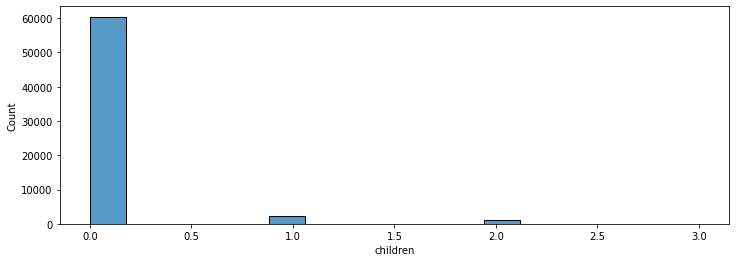

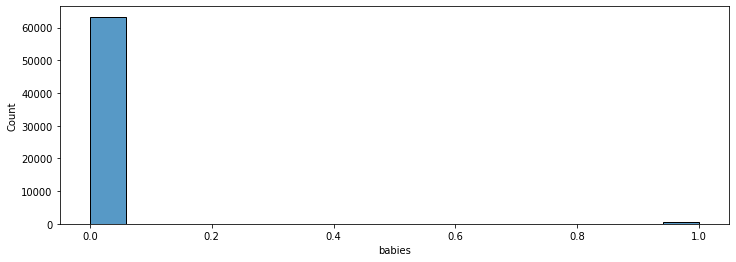

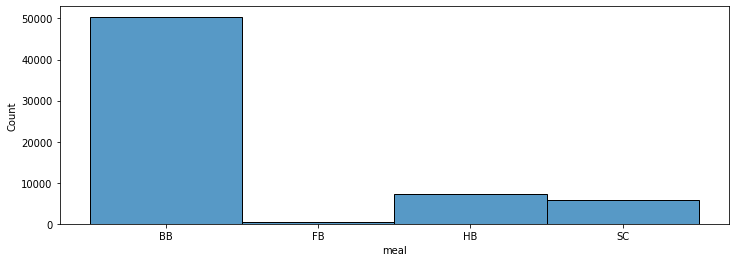

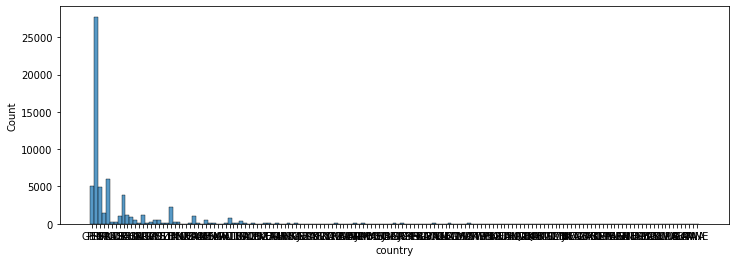

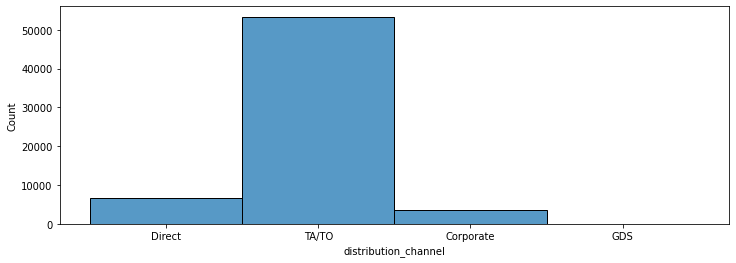

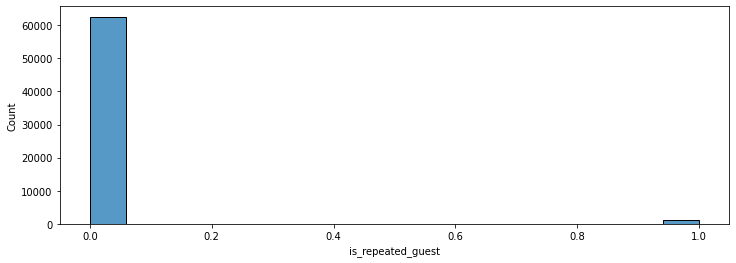

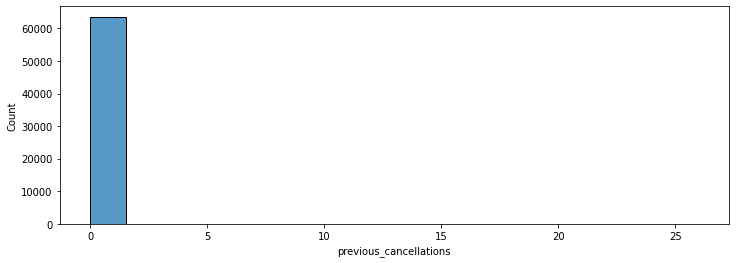

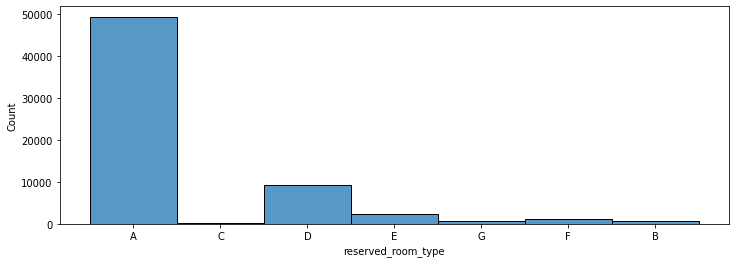

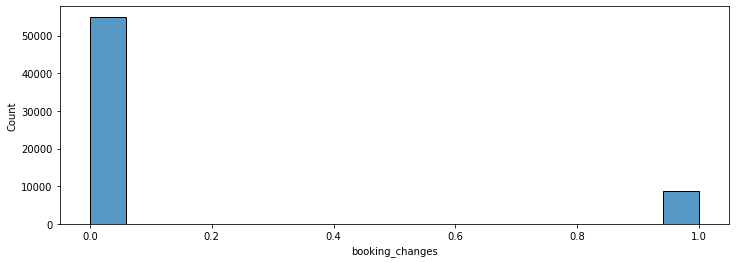

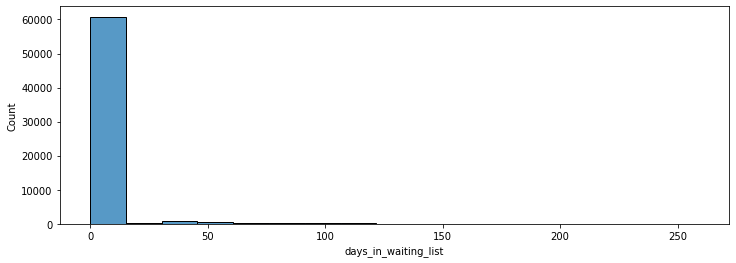

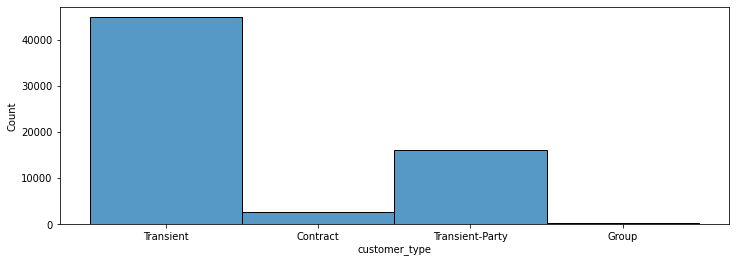

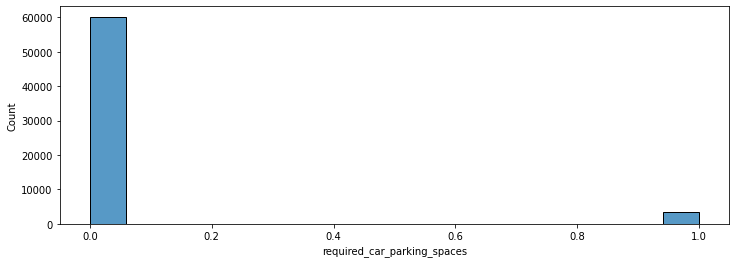

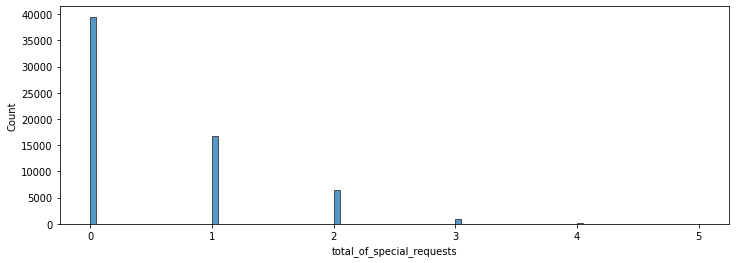

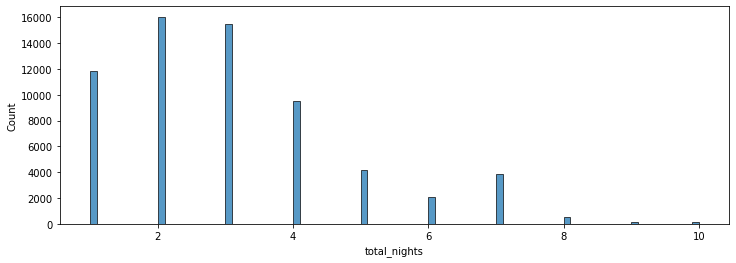

In [91]:

for col_name in df.columns:
    plt.figure(figsize=(12,4))
    sns.histplot(data=df, x=col_name)
    plt.show()

Момент со странами. График совсем неудобно смотреть, и стран-участниц очень много. Предлагаю часть стран, из которых мало людей прибывает, объединить в одну категорию. Надо теперь выбрать порог для отсечения этих стран.


In [92]:
countries = df.groupby('country')['lead_time'].count().sort_values(ascending=False)
print('среднее =', countries.mean())
mean_countries = countries.mean()
countries.describe()


среднее = 411.4193548387097


count      155.000000
mean       411.419355
std       2361.072711
min          1.000000
25%          2.000000
50%         10.000000
75%         50.000000
max      27757.000000
Name: lead_time, dtype: float64

In [93]:
countries = pd.DataFrame(data=countries)
countries.columns = ['count']
countries = list(countries.loc[countries['count']>mean_countries].index)
countries

['PRT',
 'FRA',
 'GBR',
 'ESP',
 'DEU',
 'ITA',
 'IRL',
 'BEL',
 'NLD',
 'BRA',
 'USA',
 'CHE',
 'AUT',
 'SWE',
 'POL',
 'CHN',
 'CN']

На основе этого списка категоризирую столбец со странами и использую в модели его, а не весь перечень стран.
Перед этим сохраню резервную копию датасета.

In [94]:
df_countries = df.copy()
df_countries_test = df_test.copy()

In [95]:
def new_countries(row):
    name = row['country']
    if name in countries:
        return row['country']
    else:
        return 'other'
df['new_country'] = df.apply(new_countries, axis=1)

In [96]:
df.sample(10)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,new_country
8491,0,4,2016,May,23,31,0,1,0,0,BB,PRT,TA/TO,1,0,A,0,0,Group,1,0,1,PRT
1874,0,40,2015,November,46,11,0,1,0,0,BB,PRT,Corporate,0,0,A,1,0,Transient-Party,0,0,4,PRT
59858,0,336,2016,September,39,21,1,2,0,0,BB,DEU,TA/TO,0,0,A,0,0,Transient-Party,0,0,5,DEU
54962,0,65,2016,July,28,8,2,3,0,0,BB,ITA,TA/TO,0,0,D,0,0,Transient,0,4,6,ITA
32399,1,205,2016,September,38,15,0,2,0,0,SC,USA,TA/TO,0,0,A,1,0,Transient,0,0,1,USA
60576,0,27,2016,October,41,5,0,1,0,0,BB,BEL,TA/TO,0,0,A,0,0,Transient,0,1,2,BEL
29647,1,172,2016,June,26,24,0,1,0,0,BB,PRT,TA/TO,0,0,A,0,0,Transient-Party,0,0,2,PRT
27352,1,42,2016,May,21,15,2,2,2,0,BB,THA,TA/TO,0,0,F,1,0,Transient,0,0,4,other
11969,0,38,2016,April,17,20,2,2,0,0,BB,FRA,TA/TO,0,0,E,0,0,Transient,0,1,7,FRA
36178,1,12,2016,December,50,4,2,2,0,0,BB,ESP,TA/TO,0,0,A,1,0,Transient,0,0,2,ESP


Теперь посмотрим на график:

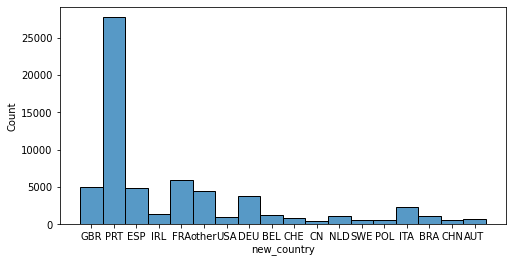

In [97]:
plt.figure(figsize=(8,4))
sns.histplot(data=df, x='new_country')
plt.show()

In [98]:
df.groupby('new_country')['lead_time'].count().sort_values(ascending=False)

new_country
PRT      27757
FRA       5945
GBR       5009
ESP       4873
other     4508
DEU       3850
ITA       2290
IRL       1437
BEL       1223
NLD       1147
BRA       1076
USA       1002
CHE        865
AUT        712
SWE        540
POL        528
CHN        524
CN         484
Name: lead_time, dtype: int64

In [99]:
df_test['new_country'] = df_test.apply(new_countries, axis=1)

In [100]:
df_test.groupby('new_country')['lead_time'].count().sort_values(ascending=False)

new_country
PRT      9788
GBR      3917
FRA      3467
other    2866
DEU      2365
ESP      1928
ITA      1149
IRL      1057
BEL       879
BRA       866
USA       769
NLD       706
CHE       599
CN        469
AUT       435
CHN       394
SWE       315
POL       238
Name: lead_time, dtype: int64

In [101]:
df = df.drop('country', axis=1)
df_test = df_test.drop('country', axis=1)

Посмотрим, как распределены посетители относительно целевого признака.

In [102]:
df.columns

Index(['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'adults', 'children', 'babies', 'meal',
       'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'reserved_room_type', 'booking_changes', 'days_in_waiting_list',
       'customer_type', 'required_car_parking_spaces',
       'total_of_special_requests', 'total_nights', 'new_country'],
      dtype='object')

In [103]:
cancel = df[df['is_canceled']==1]
no_cancel = df[df['is_canceled']==0]



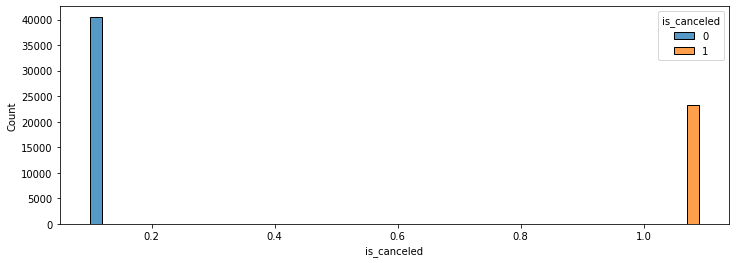

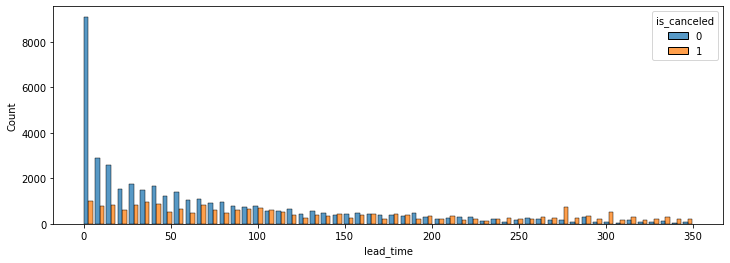

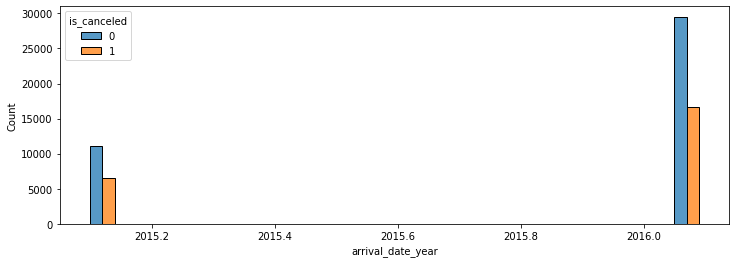

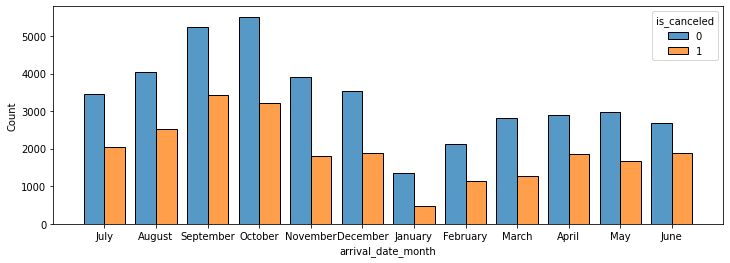

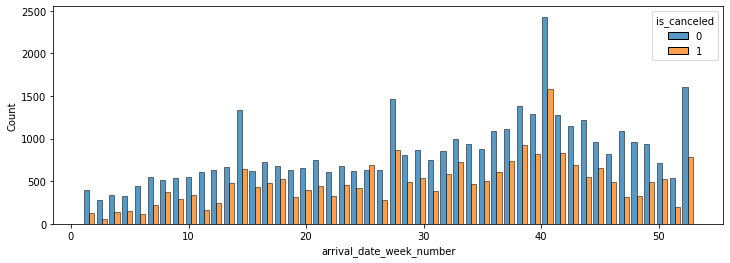

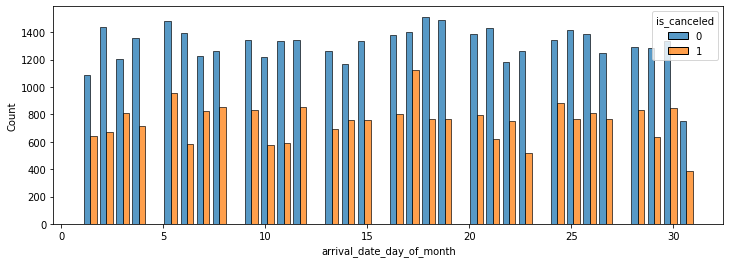

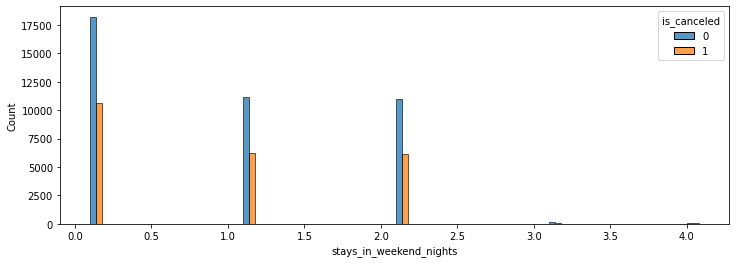

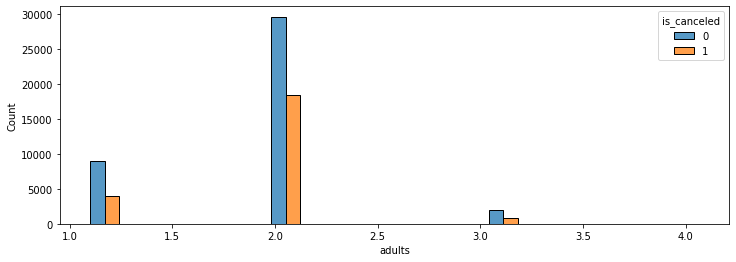

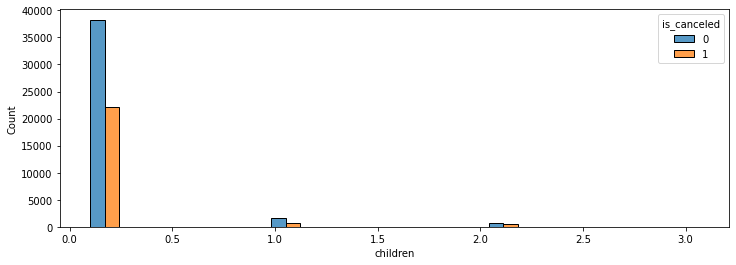

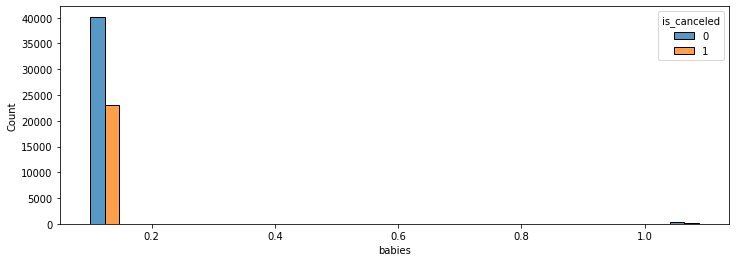

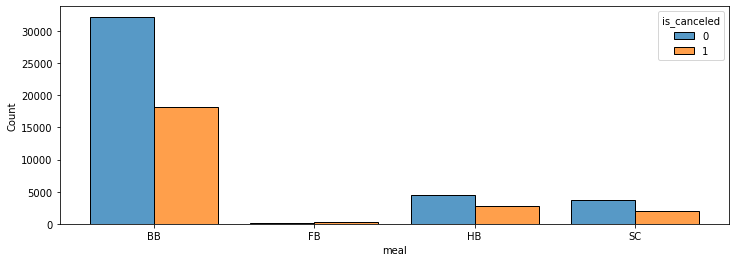

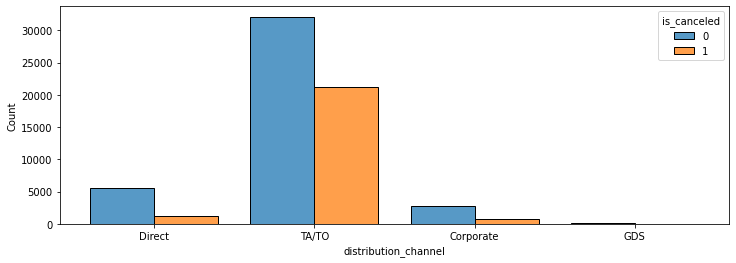

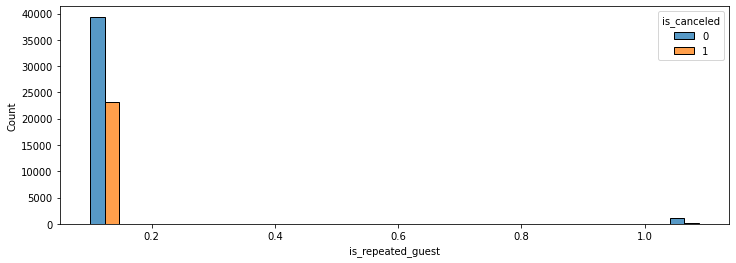

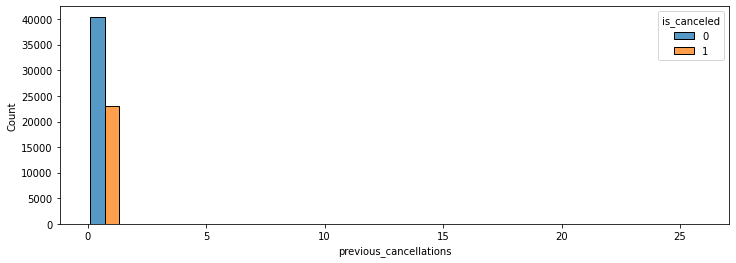

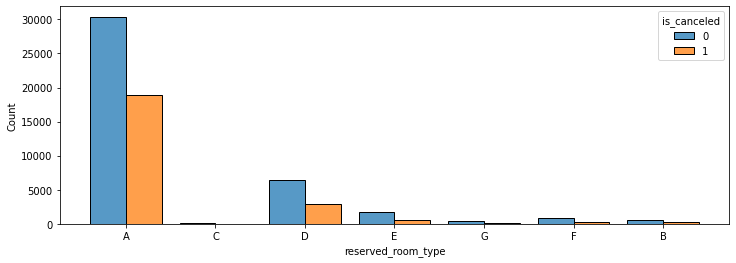

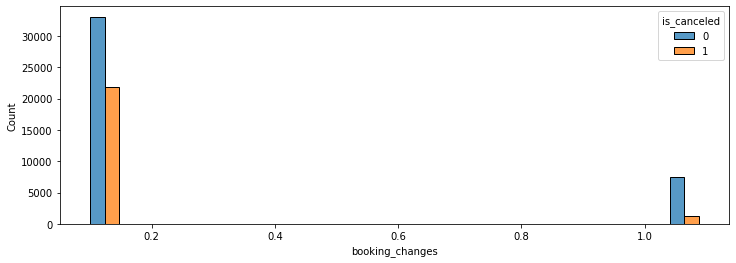

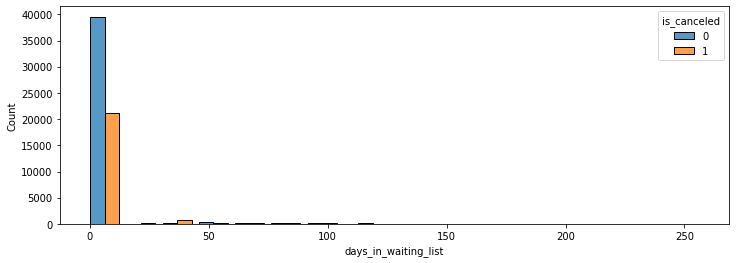

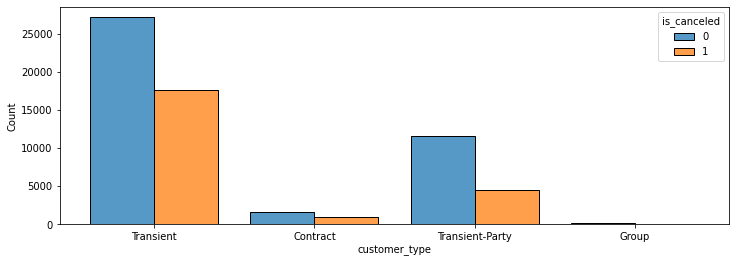

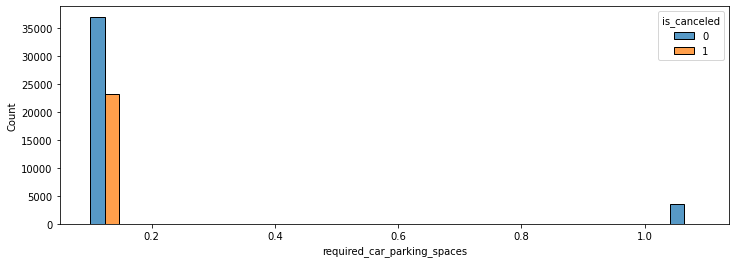

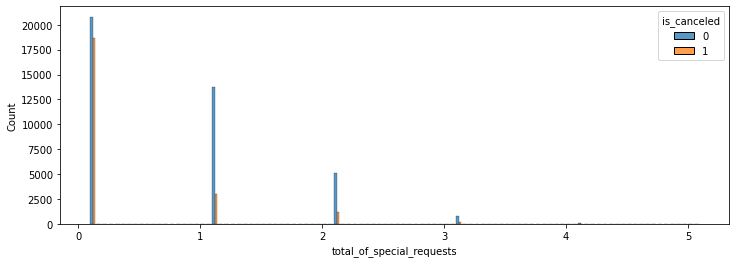

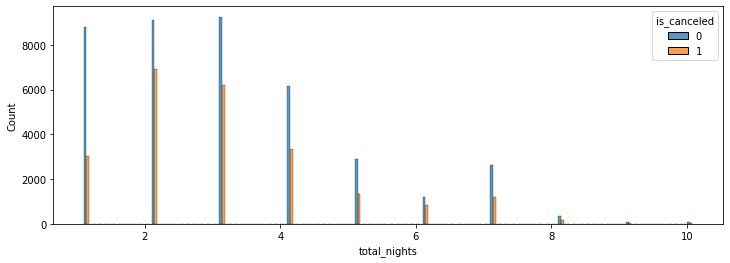

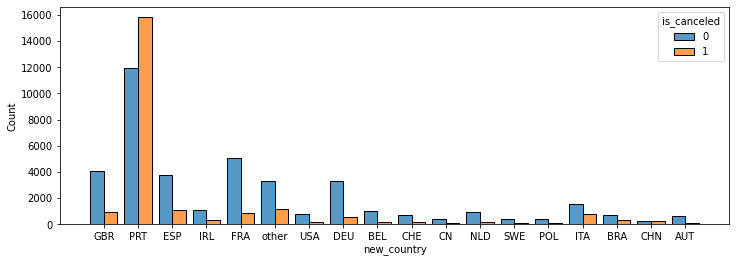

In [104]:
for col_name in cancel.columns:
    plt.figure(figsize=(12,4))
    sns.histplot(data=df, x=col_name, hue='is_canceled', multiple="dodge", shrink=.8)
    #sns.histplot(data=no_cancel, x=col_name,  color="orange")stat="density", common_norm=False, shrink=.8
    plt.show()
    
    
    
    

Немного отличаются выборки для отказавшихся и для приехавших для параметров 'lead_time', 'arrival_date_month', 'new_country'. Но больше бросается в глаза несбалансированность целевого признака.

Проанализировав данные, я пришла к выводу, что скорее всего надо удалить следующие параметры:

        'arrival_date_year' - не нужно предсказание на годы вперёд

        'arrival_date_month' - есть параметр - arrival_date_week_number - он отражает то же самое

        'arrival_date_day_of_month' - Я считаю, что этот параметр вообще не влияет на результат. Когда люди выбирают даты отпуска, они ориентируются на дни недели и месяца, начало, конец, что вполне отражает параметр 'arrival_date_week_number'

Создам резервную копию и удалю столбцы.


In [105]:
df_del = df.copy()
df_test_del = df_test.copy()

In [106]:
df = df.drop(['arrival_date_year', 'arrival_date_month'], axis=1)
df_test = df_test.drop(['arrival_date_year', 'arrival_date_month'], axis=1) 

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63770 entries, 0 to 65228
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   is_canceled                  63770 non-null  int64 
 1   lead_time                    63770 non-null  int64 
 2   arrival_date_week_number     63770 non-null  int64 
 3   arrival_date_day_of_month    63770 non-null  int64 
 4   stays_in_weekend_nights      63770 non-null  int64 
 5   adults                       63770 non-null  int64 
 6   children                     63770 non-null  int64 
 7   babies                       63770 non-null  int64 
 8   meal                         63770 non-null  object
 9   distribution_channel         63770 non-null  object
 10  is_repeated_guest            63770 non-null  int64 
 11  previous_cancellations       63770 non-null  int64 
 12  reserved_room_type           63770 non-null  object
 13  booking_changes              63

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменяет бронирование, то компания терпит убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.
Чтобы решить эту проблему, нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.


Основная бизнес-метрика - прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца.


В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.
Стоимость номеров отеля:

    категория A: за ночь — 1 000, разовое обслуживание — 400;
    категория B: за ночь — 800, разовое обслуживание — 350;
    категория C: за ночь — 600, разовое обслуживание — 350;
    категория D: за ночь — 550, разовое обслуживание — 150;
    категория E: за ночь — 500, разовое обслуживание — 150;
    категория F: за ночь — 450, разовое обслуживание — 150;
    категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.

Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.
На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период, который, кстати, не обозначен. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

Теперь рассчитаем прибыль отеля без внедрения депозитов.

In [108]:
df_profit = df_test_del[['is_canceled', 'arrival_date_month', 'arrival_date_day_of_month', 'total_nights', 'reserved_room_type']].copy()

In [109]:
df_profit.sample(8)

,is_canceled,arrival_date_month,arrival_date_day_of_month,total_nights,reserved_room_type
9727,1,March,6,4,A
5073,0,April,8,7,A
6219,0,May,28,3,A
950,1,April,28,4,D
22255,0,March,17,3,A
27102,0,May,27,5,A
17466,1,August,10,7,A
29121,0,July,2,3,A


In [110]:
month_num = {'January':1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8,\
                 'September': 9, 'October': 10, 'November': 11, 'December': 12}


In [111]:
def get_season_coefficient(value):
    if value in ['June', 'July', 'August']:
        return 1.4
    if value in ['December', 'January', 'February']:
        return 1
    else:
        return 1.2

df_profit['multiply'] = df_profit['arrival_date_month'].apply(get_season_coefficient)

In [112]:
reserved_room_type = df_profit['reserved_room_type'].unique()
reserved_room_type

array(['A', 'C', 'D', 'E', 'G', 'F', 'B'], dtype=object)

In [113]:
cost_room_type = {'A': 1000, 'B': 800, 'C': 600, 'D': 550, 'E': 500, 'F': 450, 'G': 350}
cost_clean_type = {'A': 400, 'B': 350, 'C': 350, 'D': 150, 'E': 150, 'F': 150, 'G': 150}

In [114]:
def cost_object(value, dictionary):
    return dictionary.get(value)

In [115]:
df_profit['cost_room'] = df_profit['reserved_room_type'].apply(cost_object, dictionary=cost_room_type)

In [116]:
df_profit['cost_clean'] = df_profit['reserved_room_type'].apply(cost_object, dictionary=cost_clean_type)

In [117]:
df_profit.sample(15)

,is_canceled,arrival_date_month,arrival_date_day_of_month,total_nights,reserved_room_type,multiply,cost_room,cost_clean
7116,0,July,8,7,D,1.4,550,150
4893,0,April,5,4,D,1.2,550,150
26605,0,June,19,4,D,1.4,550,150
26734,0,May,25,2,A,1.2,1000,400
27525,0,June,7,2,A,1.4,1000,400
25728,0,May,8,4,A,1.2,1000,400
7554,0,August,25,1,G,1.4,350,150
2664,0,January,2,4,G,1.0,350,150
19486,0,January,22,6,A,1.0,1000,400
22306,0,March,18,2,A,1.2,1000,400


In [118]:
# стоимость номера:   df_profit['cost_room'] * df_profit['total_nights']* df_profit['multiply']
# стоимость уборки:   df_profit['cost_clean'] *(1 + (df_profit['total_nights'] // 2))
# стоимость обслуживания отмены: df_profit['cost_room']* df_profit['multiply'] * (-1) + df_profit['cost_clean']

df_profit.loc[df_profit['is_canceled']==0, 'cost'] = (df_profit['cost_room'] * df_profit['total_nights']* df_profit['multiply']\
                                    - df_profit['cost_clean'] *(1 + (df_profit['total_nights'] // 2))) 
df_profit.loc[df_profit['is_canceled']==1, 'cost'] = ((-1)*(df_profit['cost_room']* df_profit['multiply']\
                                                      + df_profit['cost_clean']))
                                    

In [119]:
df_profit.head(15)

,is_canceled,arrival_date_month,arrival_date_day_of_month,total_nights,reserved_room_type,multiply,cost_room,cost_clean,cost
0,1,January,1,1,A,1.0,1000,400,-1400.0
1,1,January,1,4,A,1.0,1000,400,-1400.0
2,1,January,1,4,C,1.0,600,350,-950.0
3,1,January,1,4,C,1.0,600,350,-950.0
4,1,January,1,7,A,1.0,1000,400,-1400.0
5,1,January,1,7,D,1.0,550,150,-700.0
6,1,January,2,2,E,1.0,500,150,-650.0
7,1,January,2,4,G,1.0,350,150,-500.0
8,1,January,2,4,D,1.0,550,150,-700.0
9,1,January,2,5,E,1.0,500,150,-650.0


In [120]:
profit_before = df_profit['cost'].sum()

print('Выручка отеля до внедрения депозитов:', profit_before)

Выручка отеля до внедрения депозитов: 35936050.0


### Шаг 4. Разработка модели ML

In [121]:
target = df['is_canceled']
features = df.drop(['is_canceled'] , axis=1)

In [122]:
target_test = df_test['is_canceled']
features_test = df_test.drop(['is_canceled'] , axis=1)

In [123]:
target_del = df_del['is_canceled']
features_del = df_del.drop(['is_canceled'] , axis=1)

Поскольку категориальные данные в большом количестве, нужно будет их закодировать, и для этого подйдёт метод Ordinal Encoding, потому что он сохранит размер таблиц.

In [124]:

enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=352) 
enc.fit(features)

features_oe = enc.transform(features)


In [125]:
enc_del = OrdinalEncoder()
enc_del.fit(features_del)
features_del_oe = enc_del.transform(features_del)

In [126]:
target.value_counts(normalize=True)

0    0.636004
1    0.363996
Name: is_canceled, dtype: float64

Классы не сбалансированы.

Поскольку для максимизации прибыли необходимо минимизировать ложноотрицательные ответы, то главной для принятия решений будет метрика f1, чтоб сбалансировать ошибки как первого, так и второго рода.

Расмотрю модели - RandomForest, CatBoost, LogisticRegression, DecisionTree.


In [127]:
scores = {}


#### LogisticRegression

In [128]:
parameters = {'solver':('liblinear', 'newton-cg', 'sag', 'saga', 'lbfgs'), 'max_iter':[1,1000],\
              'class_weight':('balanced', 'None', [0.36, 0.63], [0.63, 0.36])}  

grid_log = GridSearchCV(LogisticRegression(random_state=RANDOM_STATE), parameters, scoring="f1", cv = 5, n_jobs= -1)
grid_log.fit(features_oe, target)

grid_log.best_params_

{'class_weight': 'balanced', 'max_iter': 1000, 'solver': 'sag'}

In [129]:
model_log = LogisticRegression(solver=grid_log.best_params_.get('solver'),\
                               max_iter=grid_log.best_params_.get('max_iter'),\
                               class_weight=grid_log.best_params_.get('class_weight'))
score_log = cross_val_score(model_log, features_oe, target, scoring="f1", cv=5)

score_log

array([0.60224121, 0.52468888, 0.63646365, 0.50299905, 0.73409543])

In [130]:
mean_score_log = np.mean(score_log)
mean_score_log

0.6000976427687592

In [131]:
scores[mean_score_log] = 'LogisticRegression'
scores

{0.6000976427687592: 'LogisticRegression'}

#### DecisionTree

In [132]:
from sklearn.tree import DecisionTreeClassifier


parameters = {'criterion': ('gini', 'entropy', 'log_loss'), 'max_depth' : [1, 10],\
              'min_samples_leaf' : [1,4], 'class_weight' : ['balanced', 'None'], 'splitter' : ('best', 'random')}


grid_tree = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE), parameters, scoring="f1", cv = 5, n_jobs= -1)   # , class_weight = 'balanced'
grid_tree.fit(features_oe, target)

grid_tree.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_leaf': 1,
 'splitter': 'random'}

In [133]:
model_tree = DecisionTreeClassifier(criterion=grid_tree.best_params_.get('criterion'),\
                                    max_depth= grid_tree.best_params_.get('max_depth'),\
                                    min_samples_leaf=grid_tree.best_params_.get('min_samples_leaf'),\
                                    class_weight= grid_tree.best_params_.get('class_weight'),\
                                    splitter=grid_tree.best_params_.get('splitter'))

score_tree = cross_val_score(model_tree, features_oe, target, scoring="f1", cv=5)

score_tree

array([0.60978789, 0.56034483, 0.65888432, 0.39492452, 0.71615202])

In [134]:
mean_score_tree = np.mean(score_tree)
mean_score_tree

0.5880187139016894

In [135]:
scores[mean_score_tree] = 'DecisionTreeClassifier'
scores

{0.6000976427687592: 'LogisticRegression',
 0.5880187139016894: 'DecisionTreeClassifier'}

#### RandomForest

In [136]:


parameters = {'n_estimators' : [1, 1000], 'max_depth' : [1, 10], 'bootstrap' : ('True', 'False')}

grid_forest = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE), parameters, scoring="f1", cv = 5, n_jobs= -1)   # , class_weight = 'balanced'
grid_forest.fit(features_oe, target)

grid_forest.best_params_

{'bootstrap': 'True', 'max_depth': 10, 'n_estimators': 1000}

In [137]:
model_forest = RandomForestClassifier(n_estimators=grid_forest.best_params_.get('n_estimators'),\
                                      max_depth=grid_forest.best_params_.get('max_depth'),\
                                      bootstrap=grid_forest.best_params_.get('bootstrap'))
score_forest = cross_val_score(model_forest, features_oe, target, scoring="f1", cv=5)
 
score_forest

array([0.53086976, 0.52007747, 0.48161481, 0.38298969, 0.79643192])

In [138]:
mean_score_forest = np.mean(score_forest)
mean_score_forest

0.5423967314196811

In [139]:
scores[mean_score_forest] = 'RandomForestClassifier'
scores

{0.6000976427687592: 'LogisticRegression',
 0.5880187139016894: 'DecisionTreeClassifier',
 0.5423967314196811: 'RandomForestClassifier'}

#### CatBoost

In [140]:
parameters_cat = {'l2_leaf_reg': [1, 15], 'iterations' : [1, 1000], 'learning_rate':[0.03, 0.07, 0.1, 0.13, 0.17],\
                         'max_depth' : [1, 10]}

grid_cat = GridSearchCV(CatBoostClassifier(random_state=RANDOM_STATE),\
                        parameters_cat, scoring="f1",  cv = 5, n_jobs= -1)
grid_cat.fit(features_oe, target, silent=True)
grid_cat.best_params_

{'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.03, 'max_depth': 1}

In [141]:
model_cat = CatBoostClassifier(l2_leaf_reg=grid_cat.best_params_.get('l2_leaf_reg'),\
                               iterations=grid_cat.best_params_.get('iterations'),\
                               learning_rate=grid_cat.best_params_.get('learning_rate'),\
                               max_depth=grid_cat.best_params_.get('max_depth'),\
                               random_state=RANDOM_STATE, silent=True)
score_cat =cross_val_score(model_cat, features_oe, target, scoring="f1", cv=5)
score_cat

array([0.60498904, 0.5459381 , 0.4403763 , 0.38349515, 0.81073366])

In [142]:
mean_score_cat = np.mean(score_cat)
mean_score_cat

0.5571064490219212

In [143]:
scores[mean_score_cat] = 'CatBoostClassifier'
scores

{0.6000976427687592: 'LogisticRegression',
 0.5880187139016894: 'DecisionTreeClassifier',
 0.5423967314196811: 'RandomForestClassifier',
 0.5571064490219212: 'CatBoostClassifier'}

In [144]:
print('Модель выбора -', scores.get(max(mean_score_cat, mean_score_forest, mean_score_tree, mean_score_log)))


Модель выбора - LogisticRegression


На кросс-валидации видим, что лучшей моделью будет логистическая регрессия.

In [145]:
features_test_oe = enc.transform(features_test)

In [147]:


model_log.fit(features_oe, target)
predicted_test = model_log.predict(features_test_oe)
print('f1:', f1_score(target_test, predicted_test))



f1: 0.6388054921740522


Теперь предскажем отказы и посчитаем, какая прибыль будет у сети отелей, если внедрить систему. Также представим крайние ситуации, когда все, кому предлагается депозит, соглашаются, и кода все отказываются.

In [148]:
predicted_test = predicted_test.astype('int64')


In [149]:
df_profit['predict'] = predicted_test

In [150]:
df_profit.sample(4)

,is_canceled,arrival_date_month,arrival_date_day_of_month,total_nights,reserved_room_type,multiply,cost_room,cost_clean,cost,predict
29057,0,July,3,1,A,1.4,1000,400,1000.0,0
24112,0,April,15,2,D,1.2,550,150,1020.0,0
14173,1,May,27,2,A,1.2,1000,400,-1600.0,1
30275,0,July,19,6,A,1.4,1000,400,6800.0,1


In [151]:
df_profit.loc[df_profit['predict']==0, 'deposite'] = 0 
df_profit.loc[df_profit['predict']==1, 'deposite'] = (df_profit['cost_room'] * df_profit['multiply'] + df_profit['cost_clean']) * 0.8


In [152]:
df_profit.sample(14)

,is_canceled,arrival_date_month,arrival_date_day_of_month,total_nights,reserved_room_type,multiply,cost_room,cost_clean,cost,predict,deposite
31519,0,August,14,4,A,1.4,1000,400,4400.0,0,0.0
29871,0,July,15,3,A,1.4,1000,400,3400.0,0,0.0
27656,0,June,8,3,A,1.4,1000,400,3400.0,0,0.0
13447,1,May,15,4,A,1.2,1000,400,-1600.0,0,0.0
2972,0,January,16,3,D,1.0,550,150,1350.0,0,0.0
21726,0,March,10,2,A,1.2,1000,400,1600.0,0,0.0
9909,1,March,12,4,A,1.2,1000,400,-1600.0,1,1280.0
14312,1,May,30,2,A,1.2,1000,400,-1600.0,1,1280.0
7937,1,January,11,1,A,1.0,1000,400,-1400.0,0,0.0
31300,0,August,10,4,F,1.4,450,150,2070.0,1,624.0


In [153]:
cost_room = list(df_profit['cost_room'])
cost_clean = list(df_profit['cost_clean'])
multiply = list(df_profit['multiply'])
total_nights = list(df_profit['total_nights'])
predict = list(df_profit['predict'])
deposite = list(df_profit['deposite'])
is_canceled = list(df_profit['is_canceled'])
cost = list(df_profit['cost'])

In [154]:

cost_predict = []
for i in range(len(cost_room)):        
    if predict[i] == 1:
        if is_canceled[i] == 0:
            cost_predict.append(cost[i])
        else: 
            cost_predict.append(cost[i] * 0.2)
    else:
        cost_predict.append(cost[i])

In [155]:
df_profit['profit'] = cost_predict


Посмотрим на "худший" сценарий. Половина из тех, кому предложено внести депозит, отказываются от услуг. ПОловину буду выбирать с помощью модуля случайных чисел.

In [156]:
import random

cost_predict_bad = []
for i in range(len(cost_room)):
    if predict[i] == 1:
        chance = random.randint(0, 1)
        if chance == 1:
            cost_predict_bad.append(0)
        else:
            cost_predict_bad.append(cost[i])
    else:
        cost_predict_bad.append(cost[i])

In [157]:
df_profit['profit_bad'] = cost_predict_bad

In [158]:
df_profit.sample(15)

,is_canceled,arrival_date_month,arrival_date_day_of_month,total_nights,reserved_room_type,multiply,cost_room,cost_clean,cost,predict,deposite,profit,profit_bad
12365,1,April,29,3,A,1.2,1000,400,-1600.0,0,0.0,-1600.0,-1600.0
29081,0,July,3,1,A,1.4,1000,400,1000.0,0,0.0,1000.0,1000.0
26955,0,May,28,2,A,1.2,1000,400,1600.0,1,1280.0,1600.0,0.0
1537,1,June,16,7,D,1.4,550,150,-920.0,1,736.0,-184.0,-920.0
12959,1,May,8,2,A,1.2,1000,400,-1600.0,1,1280.0,-320.0,0.0
19576,0,January,27,3,A,1.0,1000,400,2200.0,0,0.0,2200.0,2200.0
11951,1,April,24,5,A,1.2,1000,400,-1600.0,0,0.0,-1600.0,-1600.0
25017,0,April,28,4,A,1.2,1000,400,3600.0,1,1280.0,3600.0,3600.0
9380,1,February,25,2,E,1.0,500,150,-650.0,0,0.0,-650.0,-650.0
15811,1,June,27,1,A,1.4,1000,400,-1800.0,0,0.0,-1800.0,-1800.0


In [159]:
print('Выручка без внедрения системы депозитов:', profit_before)


Выручка без внедрения системы депозитов: 35936050.0


Поскольку это цифры для восьми месяцев, годовая прибыль будет в полтора раза выше.

In [160]:
print('Выручка после внедрения за исследуемый период, когда все, кому предложено оплатить депозит,\n соглашаются с новыми правилами:', df_profit['profit'].sum())
print('Годовая прибыль в этом случае:', (df_profit['profit'].sum() - profit_before)*1.5)
print('Выручка после внедрения за исследуемый период, когда половина из тех, кому предложено оплатить депозит,\n отказываются:', df_profit['profit_bad'].sum())
print('Годовая прибыль в этом случае:', (df_profit['profit_bad'].sum() - profit_before)*1.5)

Выручка после внедрения за исследуемый период, когда все, кому предложено оплатить депозит,
 соглашаются с новыми правилами: 44591226.0
Годовая прибыль в этом случае: 12982764.0
Выручка после внедрения за исследуемый период, когда половина из тех, кому предложено оплатить депозит,
 отказываются: 34179010.0
Годовая прибыль в этом случае: -2635560.0


Прибыль в этом случае оборачивается убытками.

Попробую найти дни, когда совершается заказ, окупающий затраты на внедрение системы.
Посчитаю, в какой день накопится разница между платой после внедрения и платой до внедрения депозитов, равная сумме, выделенной на внедрение.

In [161]:
profit = list(df_profit['profit'])

one = 0
another = 0 
summa = 400000
for i in range(len(cost_predict_bad)):
    if one >=summa:
        i_min = i
        break
    one += cost_predict_bad[i] - cost[i]
    
    
for i in range(len(profit)):
    if another >=summa:
        i_max = i
        break
    another += profit[i] - cost[i]    
    


In [162]:
df_profit[df_profit.index==i_min]

,is_canceled,arrival_date_month,arrival_date_day_of_month,total_nights,reserved_room_type,multiply,cost_room,cost_clean,cost,predict,deposite,profit,profit_bad
1275,1,May,27,7,A,1.2,1000,400,-1600.0,0,0.0,-1600.0,-1600.0


В случае отказов окупится внедрение 27 мая. Видимо, после этого дела пойдут не так хорошо, как хотелось бы.

In [163]:
df_profit[df_profit.index==i_max]

,is_canceled,arrival_date_month,arrival_date_day_of_month,total_nights,reserved_room_type,multiply,cost_room,cost_clean,cost,predict,deposite,profit,profit_bad
907,1,April,22,7,E,1.2,500,150,-750.0,1,600.0,-150.0,0.0


В случае согласия окупится внедрение 22 апреля.

Вывод:
Внедрение системы в лучшем случае окупится за четыре месяца и принесёт прибыль в год чуть более 12 миллионов денег.

Однако, в среднем внедрение системы принесёт убытки в 2,7 миллионов.

### Шаг 5. Опишите портрет «ненадёжного» клиента

Определим, какие параметры сильнее влияли на предсказания, и по ним составим портрет нежелательного клиента.

In [164]:


feature_names = [f"{i}" for i in features_test.columns]

result = permutation_importance(
    model_log, features_test_oe, target_test, n_repeats=10, random_state=RANDOM_STATE, n_jobs=2
)

feature_importances = pd.Series(result.importances_mean, index=feature_names)

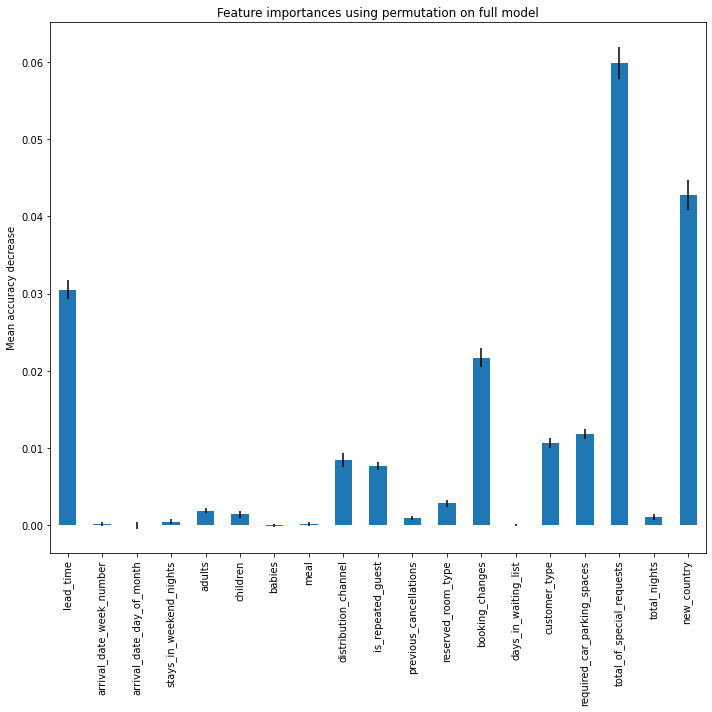

In [165]:
#plt.figure(figsize=(10, 10))
fig, ax = plt.subplots()
feature_importances.plot.bar(yerr=result.importances_std, ax=ax,figsize=(10, 10))
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [166]:
print(round(feature_importances.sort_values(ascending=False), 4))

total_of_special_requests      0.0600
new_country                    0.0428
lead_time                      0.0305
booking_changes                0.0217
required_car_parking_spaces    0.0118
customer_type                  0.0106
distribution_channel           0.0084
is_repeated_guest              0.0076
reserved_room_type             0.0028
adults                         0.0019
children                       0.0014
total_nights                   0.0010
previous_cancellations         0.0010
stays_in_weekend_nights        0.0004
arrival_date_week_number       0.0001
meal                           0.0001
days_in_waiting_list           0.0000
arrival_date_day_of_month     -0.0000
babies                        -0.0001
dtype: float64



    Основными факторами, по которым можно судить о вероятности отказа, становятся:
        total_of_special_requests - клоичество специфических пожеланий, 
        new_country - страна, из которой едет гость, 
        lead_time - время, которое проходит между бронированием и визитом,
        booking_changes - сколько изменений в заказ было внесено.
        

In [167]:
special_requests = df_test.groupby('total_of_special_requests')['is_canceled'].agg(['mean', 'count']).sort_values('mean', ascending=False)
display('Количество специальных отметок:', special_requests.query('mean > 0'))



'Количество специальных отметок:'

,mean,count
total_of_special_requests,,
0,0.496062,17266
1,0.279908,9964
2,0.262624,3941
3,0.171141,894
4,0.104839,124
5,0.055556,18


Специальных отметок - 0-3.

In [168]:
sort_country = df_test.groupby('new_country')['is_canceled'].agg(['mean', 'count']).sort_values('mean', ascending=False)
sort_country = sort_country.query('count > 10').reset_index()
country_bad = list(sort_country['new_country'][:11])
display('10 худших стран:', sort_country.head(10))


'10 худших стран:'

,new_country,mean,count
0,PRT,0.601757,9788
1,CHN,0.494924,394
2,BRA,0.449192,866
3,ITA,0.426458,1149
4,other,0.340893,2866
5,ESP,0.317946,1928
6,IRL,0.315043,1057
7,CHE,0.307179,599
8,USA,0.306892,769
9,POL,0.302521,238


In [169]:
sort_lead_time = df_test.groupby('lead_time')['is_canceled'].agg(['mean', 'count'])
sort_lead_time = sort_lead_time.reset_index().sort_values('lead_time', ascending=True)
display('Вероятность отказа от брони больше 50% при ожидании более: ', sort_lead_time.query('mean > 0.5'))

'Вероятность отказа от брони больше 50% при ожидании более: '

,lead_time,mean,count
28,28,0.561290,310
37,37,0.556452,124
38,38,0.690265,226
52,52,0.633136,169
54,54,0.637584,149
...,...,...,...
362,365,1.000000,2
363,366,1.000000,1
365,368,0.805556,36
366,372,1.000000,11


При ожидании более 28 дней.

In [170]:
make_changes = df_test.groupby('booking_changes')['is_canceled'].agg(['mean', 'count']).sort_values('mean', ascending=False)
display('Перед отказом сделано изменений:', make_changes.query('mean > 0'))


'Перед отказом сделано изменений:'

,mean,count
booking_changes,,
0,0.426134,27604
1,0.172279,4603


Даже те, кто не вносят изменений, отменяют визит.

    Ненадёжный клиент:
        Не делал специальных отметок в заказе 
        Приезжает из стран 'PRT', 'CHN', 'BRA', 'ITA', 'ESP', 'IRL', 'CHE', 'USA', 'POL'. И не мала вероятность отказа, если из страны клиента приезжает слишком мало посетителей.
        Бронирует номер за 4 недели и более
        Бронь не изменял.

### Шаг 6. Напишите общий вывод

    Для решения задачи о внедрении системы депозитов для компенсации затрат отелей из-за отказов мы получили два датасета с информацией о трёх годах работы отеля.
    На предобработке данных я удалила редкие значения и выбросы, изменила числовые значения на целые, потому что нет необходимости в дробных значениях, удалила пробелы.
    Для обучения моделей кодировала категориальные данные методом OrdinalEncoder. Кросс-валидацией по метрике f1 выбрала моделью для предсказания LogisticRegression.
    Чтобы сравнить изменения в прибыльности, рассчитала по тестовой выборке доход как есть, а потом на том же периоде - по предсказанным даным. Нашла день, в который доход перекроет затраты на внедрение системы.
    Выяснила, какие фичи сильнее влияют на предсказанния, и нашла по самым влиятельным значения, при которых клиент с большей вероятностью откажется от поездки. 
    
    
    Внедрение системы не рекомендуется, потому что скорее всего принесёт убытки. 

    Ненадёжный клиент:
        Не делал специальных отметок в заказе 
        Приезжает из стран 'PRT', 'CHN', 'BRA', 'ITA', 'ESP', 'IRL', 'CHE', 'USA', 'POL'. И не мала вероятность отказа, если из страны клиента приезжает слишком мало посетителей.
        Бронирует номер за 4 недели и более
        Бронь не изменял.
